# 概述

欢迎访问我的个人Github查看更多内容（国内访问Github可能存在问题，可以换个时间段访问，或者百度解决方案）： https://github.com/charliedream1/ai_quant_trade

本文采用了聚宽因子库共260个因子作为示例（由于数据接口存在访问量限制，下文示例仅使用了60个因子，并挑选了15值股票，半年的时间作为训练数据，演示整个流程）。

聚宽因子库，共260个因子：https://www.joinquant.com/help/api/help#name:factor_values

本文主要讲解采用260因子，以及lightGBM模型，采用TopKDropN策略选股调仓的详细流程和分析过程。策略主要流程如下：   
* 将时间拆分为训练/验证/测试三个时间段，使用聚宽260因子库，获取股票因子，数据维度是T*D(T即时间1维，D是因子维度)
* 使用LightGBM进行训练，并进行预测
* 对“涨”概率值排序，选择TopK的股票。对持仓股票预测，“跌”的概率排序，做空N个股票

# 1. 机器学习/深度学习训练总结

## 1.1 常见训练数据使用方式；    
1.使用基础数据，通过技术指标统计多天，将时间维度压成1维（如5日均值，将5日统计为1日），即1支股票是一个（1*N）维度的特征,
  1为时间，N为特征的维度    
2.采用滑动窗口，保留时间维，即1支股票是一个（T*N）维度的特征   


## 1.2 特征选择     
不同周期，不同因子的重要性不同，因此，特征选择主要有一下方案：        
1.采用尽可能多的因子，因子不变，固定周期重训模型，以保持模型的稳定     
2.固定周期，根据因子权重，重选因子后，重训模型   

特征处理：    
1. 去极值，标准化，归一化
2. nan值剔除，或用0/均值填充
3. 通过模型进行因子权重打分进行选择
4. 通过特征降维算法压缩


## 1.3 训练和验证数据拆分流程 （优选方案1或2）             
1.按时间段，比如2018年为训练，2019年为验证集，2020做测试集     
2.比如2018年等分切分为12分，奇数作训练，偶数做验证，2019做测试机     
3.对训练集直接打散后，7：3拆分为训练和验证集，小概率情况下出现行情好的都分到了训练集，
  行情差的都在验证集，可能导致训练的不好。


## 1.4 标签制作和使用
1.回归类标签：即使用实际股票价值，或者涨跌幅作为预测值，但往往误差较大，可能预测不准，虽然分析过程，
  通过绘图，可以看到预测趋势和真实值很接近，但实际误差仍然很大
2.分类标签：相对回归会更加准确，但是需要大量的尝试以及精细分类，比如最简单的分类，就是预测涨还是跌，
  如果分类详细一些，则是按涨跌幅度分为几类，进行预测。得到预测结果后，可以按照打分进行排序后选股。


## 1.5 回测中可能存在的问题     
### 1.5.1 模拟和真实的差异
回测和真是交易存在一定的差异，因此，只可能尽可能接近实际的模拟，但和真实存在一定差异，如：    
1.概率性买入失败：真实交易可能存在涨跌停导致没有买入或卖出，而回测无法很好的模拟    
2.滑点：由于价格快速实时波动，导致下单和实际成交价格存在差异，回测往往采用一个固定比率模拟    
3.交易值：回测往往采取一天的收盘价或者平均价作为交易价格，与实际存在差异

### 1.5.2 注意事项
需注意引入未来 （深度学习中Attention网络注意对未来进行mask,其余模型对日期进行平移）

### 1.5.3 测试流程
如果回测周期很长，比如8年，那么行情好的期间可能掩盖行情不好期间的亏损问题。
因此，建议对牛市/熊市/长周期（比如连续2年+），之后对近期模拟交易跟踪，综合评定后，
如果策略Okay，则上线使用。

# 2. 待调试超参数

In [1]:
# 通过同花顺，查看上证指数，月线，挑选时间段
# 市场行情很好（大盘指数约从2118-4611点）：2014-4-30: 2015-5-30
# 市场行情较好 (大盘指数约从2807-3497点) 2020-04-30：2021-11-30 
# 市场行情不好 (大盘指数约从3413-2618) 2018-1-30: 2019-1-31 
market_pool = '000300.XSHG'  # 沪深300
train = ['2020-06-30', '2020-12-30']
eval = ['2021-01-01', '2021-02-20']
test = ['2021-03-31', '2021-05-30']

market_pool = '000300.XSHG'  # 用沪深300作为选股股票池
view_len = 20  # 滑动窗口查看的天数
stk_num = 10 # 数据量大运算事件过长，暂时只选择15个
factor_num = 60  # 因子使用的数量，数据量大运算事件过长，暂时只选择80个

# 3. 数据准备
## 3.1 获取股票列表

In [3]:
from jqlib.technical_analysis import *
from jqdata import *

# 获取沪深300股票列表
hs300_stock_lst = get_index_stocks(market_pool)
hs300_stock_lst = hs300_stock_lst[:stk_num]
print('Total Num:', len(hs300_stock_lst))
print(hs300_stock_lst[:10])

Total Num: 15
['000001.XSHE', '000002.XSHE', '000063.XSHE', '000066.XSHE', '000069.XSHE', '000100.XSHE', '000157.XSHE', '000166.XSHE', '000301.XSHE', '000333.XSHE']


## 3.2 获取股票数据

In [4]:
# get_price 取多只股票数据时, 为了对齐日期, 不能跳过停牌
# todo:考虑每支股票分开处理，过滤停牌的日期
# 获取一支或者多只股票的行情数据, 按天或者按分钟，这里在使用时注意 end_date 的设置，
#   传入的值不要大于context.current_dt，否则会引入未来函数。
# 关于停牌: 因为此API可以获取多只股票的数据, 可能有的股票停牌有的没有, 为了保持时间轴的一致
# panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败
#df = get_price(hs300_stock_lst, start_date=train[0], end_date=train[1], 
#               frequency='daily', skip_paused=False, fill_paused=True, panel=True)

# 最好并行获取单只股票信息
df = get_price(hs300_stock_lst[0], start_date=train[0], end_date=train[1], 
               frequency='daily', skip_paused=False, fill_paused=True, panel=True)
df.head()

,open,close,high,low,volume,money
2020-06-30,12.50,12.48,12.55,12.40,96232862.0,1.199182e+09
2020-07-01,12.47,12.79,12.82,12.42,174152569.0,2.202801e+09
2020-07-02,12.75,13.09,13.15,12.64,265785962.0,3.433511e+09
2020-07-03,13.23,13.89,13.96,13.22,386631816.0,5.280918e+09
2020-07-06,14.23,15.28,15.28,14.22,483396858.0,7.168653e+09


## 3.3 获取因子（聚宽260因子）

In [5]:
#获取聚宽因子库所有因子
from jqfactor import get_all_factors 
df_factors_info = get_all_factors()
print(df_factors_info.head())
print('Num: ', len(df_factors_info))

                       factor      ...       category_intro
0  administration_expense_ttm      ...           基础科目及衍生类因子
1   asset_impairment_loss_ttm      ...           基础科目及衍生类因子
2    cash_flow_to_price_ratio      ...           基础科目及衍生类因子
3      circulating_market_cap      ...           基础科目及衍生类因子
4                        EBIT      ...           基础科目及衍生类因子

[5 rows x 4 columns]
Num:  260


In [7]:
factor_lst = list(df_factors_info['factor'])[:factor_num]  # 只选择80个，选择太多，时间过长，而且有调用限制
print(factor_lst[:3])

['administration_expense_ttm', 'asset_impairment_loss_ttm', 'cash_flow_to_price_ratio']


In [28]:
# 导入函数库
from jqfactor import get_factor_values

# 为了防止单次返回数据时间过长，每次调用 api 请求的因子值不能超过 200000 个
# 因子库中nan值：缺少依赖数据;财务数据中如果标的未披露相关字段,依赖数据不完整的话会返回nan值,请注意到财务报表披露规则变更,标的报表披露形式(金融类,非金融类等) , 以及标的上市时间等

# 返回：
# * 一个 dict： key 是因子名称， value 是 pandas.dataframe。
# # dataframe 的 index 是日期， column 是股票代码， value 是因子值

factor_data = get_factor_values(securities=['000001.XSHE'], factors=factor_lst, 
                                start_date=train[0], end_date=train[1])

# 查看因子值
factor_data['AR'].head()

code,000001.XSHE
2020-06-30,79.321560
2020-07-01,99.755665
2020-07-02,116.372405
2020-07-03,143.123404
2020-07-06,180.262966


# 4. 模型数据准备
注意：sklearn类模型不支持2D数据，即时间维度必须是1，每一行一个标签值
## 4.1 分类模型数据准备
### 4.1.1 实验测试

In [18]:
# 判断涨或者跌
df_lab = df['close'] - df['open']
print(df_lab.head())
type(df_lab)

2020-06-30   -0.02
2020-07-01    0.32
2020-07-02    0.34
2020-07-03    0.66
2020-07-06    1.05
dtype: float64


pandas.core.series.Series

In [19]:
tmp = df.iloc[1: 1 + view_len, :].values
print('value:', tmp[:2])
print('shape:', tmp.shape)
print('type', type(tmp))

value: [[12.47 12.79 12.82 12.42 174152569.0 2202800843.97]
 [12.75 13.09 13.15 12.64 265785962.0 3433511084.46]]
shape: (20, 6)
type <class 'numpy.ndarray'>


In [20]:
arr = df.values
arr[0, 0:3]

array([12.5, 12.48, 12.55])

In [21]:
# 由于是3D数据，这种方式只适合深度学习模型使用
import numpy as np
x, y = [], []
# -1用于错开数据和标签，避免引入未来
for i in range(1, len(df) - view_len - 1):
    ft = df.iloc[i: i + view_len, :].values
    x.append(ft)
    if df_lab[i+1] > 0:
        y.append(1)
    else:
        y.append(0)

print('x', x[:1])
print('y', y[:1])

x [array([[12.47, 12.79, 12.82, 12.42, 174152569.0, 2202800843.97],
       [12.75, 13.09, 13.15, 12.64, 265785962.0, 3433511084.46],
       [13.23, 13.89, 13.96, 13.22, 386631816.0, 5280918011.4],
       [14.23, 15.28, 15.28, 14.22, 483396858.0, 7168653356.25],
       [15.89, 15.09, 16.21, 14.65, 406751085.0, 6267919683.04],
       [14.84, 15.36, 15.59, 14.84, 269975946.0, 4095447757.17],
       [15.26, 15.14, 15.26, 14.92, 230234293.0, 3469517329.73],
       [14.96, 14.48, 15.09, 14.39, 221490586.0, 3254272377.89],
       [14.33, 14.51, 14.7, 14.13, 198753032.0, 2871414844.76],
       [14.52, 14.31, 14.81, 14.18, 200436306.0, 2891773817.07],
       [14.41, 13.91, 14.48, 13.87, 209567372.0, 2947173149.72],
       [13.94, 13.79, 14.18, 13.76, 198109849.0, 2771496391.19],
       [13.81, 13.78, 13.92, 13.6, 132492448.0, 1821043927.51],
       [13.87, 14.36, 14.4, 13.74, 203110656.0, 2872758056.19],
       [14.31, 14.12, 14.31, 14.04, 128544281.0, 1815570300.6],
       [14.12, 14.04, 14.28

In [38]:
x[1].shape

(20, 6)

In [40]:
# 由于是3D数据，sklearn只支持2D数据，所以会报错
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(x, y)

ValueError: Found array with dim 3. Estimator expected <= 2.

# 4.1.2 训练测试数据准备

In [7]:
# 标签制作样例
df = pd.DataFrame({
   'A': [4.0405, 4.0963, 4.3149, 3.986],
    'B': [1.7246, 1.7482, 1.8519, 1.822],
     'C': [804.74, 810.01, 860.13, 790.11]},
     index=['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01'])
print('1.ori: \n', df)
df['lab'] = df['C'].pct_change()
print('2.add pct_chg:\n', df)
# print(df.pct_change(axis='columns'))  # 可以指定按照行还是列进行计算的

# 往上移动一行，即标签是今天预测明天
df['lab'] = df['lab'].shift(periods=-1, axis=0) 
print('3.shift df:\n', df)
# 上移后，最后一行会出现nan值，丢弃
df = df.dropna()

import numpy as np
df['lab'] = np.where(df['lab'] > 0, 1, 0)
print('4.generate lab: \n', df)

1.ori: 
                  A       B       C
1980-01-01  4.0405  1.7246  804.74
1980-02-01  4.0963  1.7482  810.01
1980-03-01  4.3149  1.8519  860.13
1980-04-01  3.9860  1.8220  790.11
2.add pct_chg:
                  A       B       C       lab
1980-01-01  4.0405  1.7246  804.74       NaN
1980-02-01  4.0963  1.7482  810.01  0.006549
1980-03-01  4.3149  1.8519  860.13  0.061876
1980-04-01  3.9860  1.8220  790.11 -0.081406
3.shift df:
                  A       B       C       lab
1980-01-01  4.0405  1.7246  804.74  0.006549
1980-02-01  4.0963  1.7482  810.01  0.061876
1980-03-01  4.3149  1.8519  860.13 -0.081406
1980-04-01  3.9860  1.8220  790.11       NaN
4.generate lab: 
                  A       B       C  lab
1980-01-01  4.0405  1.7246  804.74    1
1980-02-01  4.0963  1.7482  810.01    1
1980-03-01  4.3149  1.8519  860.13    0


In [2]:
from jqfactor import get_factor_values
from jqfactor import get_all_factors 
from tqdm import tqdm
import numpy as np
from jqlib.technical_analysis import *
from jqdata import *

# 获取沪深300股票列表
hs300_stock_lst = get_index_stocks(market_pool)
hs300_stock_lst = hs300_stock_lst[:stk_num]

# 获取因子列表
df_factors_info = get_all_factors()
factor_lst = list(df_factors_info['factor'])[:factor_num]  # 只选择60个，选择太多，时间过长，而且有调用限制

def prepare_data(hs300_stock_lst, factor_lst, start_time, end_time):
    # 获取数据
    df_dict = {}  # stk_code: df values

    total_num = len(hs300_stock_lst) * len(factor_lst)  # 特征总数
    pbar = tqdm(total_num)
    cnt = 0
    sample_code = ''  # 用于最后打印显示其中一支股票的数据信息

    for code in hs300_stock_lst:
        factor_dict = get_factor_values(securities=[code], factors=factor_lst, 
                                    start_date=start_time, end_date=end_time) 
        df_base = get_price(code, start_date=start_time, end_date=end_time, 
                   frequency='daily', skip_paused=True)  # , fill_paused=True, panel=False)

        # 将因子数据和基础数据合并
        for factor, df_ft_vals in factor_dict.items():
            pbar.update(1)
            cnt += 1
            pbar.set_description("Processing %s: (%d / %d)" % (code, cnt, total_num))
            
            # df_base过滤停牌后和df_base时间维度长度可能不一致
            if len(df_base) == len(df_ft_vals):
                df_base[factor] = df_ft_vals

        if len(df_base):
            sample_code = code
            # 把数据表中的空值用0来代替
            df_base.fillna(0, inplace=True)

            # 添加标签
            df_base['lab'] = df_base['close'].pct_change()

            # 往上移动一行，即标签是今天预测明天
            df_base['lab'] = df_base['lab'].shift(periods=-1, axis=0) 

            # 上移后，最后一行会出现nan值，丢弃
            df_base = df_base.dropna()
            # 生成1，0标签，1-涨，0-跌
            df_base['lab'] = np.where(df_base['lab'] > 0, 1, 0)
            df_dict[code] = df_base

    pbar.close()

    print('Data Process Complete!!!')
    print('Data Shape:', df_dict[sample_code].shape)
    print(df_dict[sample_code].head())

    # 合并所有股票数据
    df_all = pd.concat(df_dict.values(), sort=False)
    print('Concat Data Shape:', df_all.shape)

    y = df_all['lab']
    # del df_all['lab']，这种方法会影响df_dict里的数据，后续df_dict里的lab列无法获取
    x = df_all.loc[:, df_all.columns != 'lab']
    print('x shape:', x.shape)
    print('y shape:', y.shape)
    return x, y, df_dict

# 准备训练数据
print('===' * 20)
print('1.Train Data Prepare')
x_train, y_train, df_train_dict = prepare_data(hs300_stock_lst, factor_lst, train[0], train[1])
ft_names = x_train.columns

# 准备验证数据
print('===' * 20)
print('2.Eval Data Prepare')
x_eval, y_eval, df_eval_dict = prepare_data(hs300_stock_lst, factor_lst, eval[0], eval[1])

# 准备测试数据
print('===' * 20)
print('3.Test Data Prepare')
x_test, y_test, df_test_dict = prepare_data(hs300_stock_lst, factor_lst, test[0], test[1])

0it [00:00, ?it/s]

1.Train Data Prepare


Processing 000333.XSHE: (600 / 600): : 600it [00:31, 19.26it/s]
0it [00:00, ?it/s]

Data Process Complete!!!
Data Shape: (125, 67)
             open  close   high ...           AR  retained_earnings  lab
2020-06-30  57.01  56.82  57.97 ...    99.243349       8.397603e+10    1
2020-07-01  56.73  59.33  59.38 ...   121.392520       8.397603e+10    1
2020-07-02  58.73  59.82  60.26 ...   147.406108       8.397603e+10    0
2020-07-03  59.96  59.29  60.77 ...   139.727551       8.397603e+10    1
2020-07-06  59.69  60.84  61.76 ...   147.176126       8.397603e+10    1

[5 rows x 67 columns]
Concat Data Shape: (1249, 67)
x shape: (1249, 66)
y shape: (1249,)
2.Eval Data Prepare


Processing 000333.XSHE: (600 / 600): : 600it [00:15, 38.97it/s]
0it [00:00, ?it/s]

Data Process Complete!!!
Data Shape: (29, 67)
             open  close    high ...           AR  retained_earnings  lab
2021-01-04  93.98  94.08   96.88 ...   121.187584       9.005129e+10    1
2021-01-05  93.19  96.49   96.87 ...   128.701675       9.005129e+10    0
2021-01-06  97.88  95.94   99.59 ...   121.527139       9.005129e+10    1
2021-01-07  96.93  99.60  100.41 ...   124.348942       9.005129e+10    0
2021-01-08  98.83  97.88   99.49 ...   113.924583       9.005129e+10    0

[5 rows x 67 columns]
Concat Data Shape: (290, 67)
x shape: (290, 66)
y shape: (290,)
3.Test Data Prepare


Processing 000333.XSHE: (600 / 600): : 600it [00:16, 36.39it/s]


Data Process Complete!!!
Data Shape: (38, 67)
             open  close   high ...          AR  retained_earnings  lab
2021-03-31  78.68  78.14  78.85 ...   71.853763       9.005129e+10    1
2021-04-01  77.92  81.18  81.61 ...   80.177029       9.005129e+10    1
2021-04-02  81.25  82.78  84.10 ...   90.266181       9.005129e+10    0
2021-04-06  82.82  80.18  83.34 ...   80.613002       9.005129e+10    0
2021-04-07  80.18  78.60  80.29 ...   74.490695       9.005129e+10    0

[5 rows x 67 columns]
Concat Data Shape: (369, 67)
x shape: (369, 66)
y shape: (369,)


In [3]:
# 检查每一列是否包含nan值
print('x\n', x_train.isna().sum())
print('y\n', y_train.isna().sum())
print(y_train.head())

# 填充nan值
x_train = x_train.fillna(0)
y_train = y_train.fillna(0)

x_eval = x_eval.fillna(0)
y_eval = y_eval.fillna(0)

x_test = x_eval.fillna(0)
y_test = y_eval.fillna(0)

# 对数据特征进行标准化处理
# 此处，通过自己写公式的方式统计训练集的均值方差，然后保存，应用在eval和test集更好
#  不太确定sklearn是否可以使用train中固定参数应用在eval/test上 
from sklearn import preprocessing
scaler=preprocessing.StandardScaler()
x_train=scaler.fit_transform(x_train)
x_eval=scaler.transform(x_eval)
x_test=scaler.transform(x_test)

x
 open                                        0
close                                       0
high                                        0
low                                         0
volume                                      0
money                                       0
operating_profit_ttm                      124
np_parent_company_owners_ttm              124
net_interest_expense                      124
sales_to_price_ratio                      124
net_debt                                  124
EBITDA                                    124
total_operating_revenue_ttm               124
OperateNetIncome                          124
BR                                        124
TVSTD6                                    124
DAVOL20                                   124
VDEA                                      124
TVMA6                                     124
DAVOL10                                   124
interest_free_current_liability           124
financial_liability            

# 5. 模型训练
## 5.1 使用单支股票训练预测

In [4]:
# ======= 1. 数据准备  ========
code = list(df_train_dict.keys())[0]  # 取一支股票
df_train_data = df_train_dict[code]
#df_train_data.head()
y_train1 = df_train_data['lab']
x_train1 = df_train_data.loc[:, df_train_data.columns != 'lab']

df_eval_data = df_eval_dict[code]
y_test1 = df_eval_data['lab']
x_test1 = df_eval_data.loc[:, df_eval_data.columns != 'lab']

# 填充nan值
x_train1 = x_train1.fillna(0)
y_train1 = y_train1.fillna(0)

x_test1 = x_test1.fillna(0)
y_test1 = y_test1.fillna(0)

version 2.2.2
The accuracy of the LGB is: 1.0
The accuracy of the LGB is: 0.5517241379310345
The confusion matrix result:
 [[10 8]
 [5 6]]


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


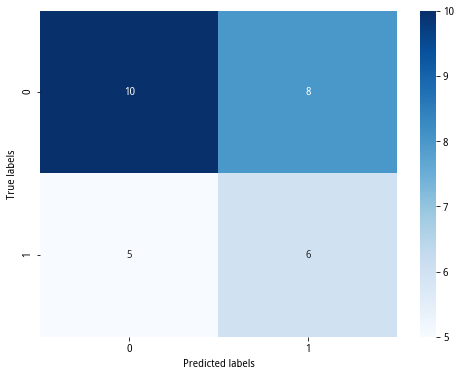

In [40]:
# ======= 2. 模型训练  ========
# sklearn接口形式
import lightgbm as lgb
import seaborn as sns
print('version', lgb.__version__)

# ## 导入LightGBM模型
from lightgbm.sklearn import LGBMClassifier
# ## 定义 LightGBM 模型 
clf = LGBMClassifier(verbose=1)
# # 在训练集上训练LightGBM模型
clf.fit(x_train1, y_train1)
## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train1)
test_predict = clf.predict(x_test1)

from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The accuracy of the LGB is:',metrics.accuracy_score(y_train1,train_predict))
print('The accuracy of the LGB is:',metrics.accuracy_score(y_test1,test_predict))

## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test1)
print('The confusion matrix result:\n',confusion_matrix_result)

# 利用热力图对于结果进行可视化
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# 5.2 使用所有股票训练预测

version 2.2.2
[1]	valid_0's l1: 0.500712	valid_0's binary_logloss: 0.69546
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.5003	valid_0's binary_logloss: 0.69538
[3]	valid_0's l1: 0.498817	valid_0's binary_logloss: 0.6929
[4]	valid_0's l1: 0.497451	valid_0's binary_logloss: 0.690659
[5]	valid_0's l1: 0.496592	valid_0's binary_logloss: 0.690056
[6]	valid_0's l1: 0.495648	valid_0's binary_logloss: 0.688976
[7]	valid_0's l1: 0.495256	valid_0's binary_logloss: 0.689819
[8]	valid_0's l1: 0.495557	valid_0's binary_logloss: 0.690882
[9]	valid_0's l1: 0.494932	valid_0's binary_logloss: 0.690215
[10]	valid_0's l1: 0.494326	valid_0's binary_logloss: 0.689677
[11]	valid_0's l1: 0.493087	valid_0's binary_logloss: 0.687191
[12]	valid_0's l1: 0.492137	valid_0's binary_logloss: 0.685722
[13]	valid_0's l1: 0.491421	valid_0's binary_logloss: 0.685584
[14]	valid_0's l1: 0.490473	valid_0's binary_logloss: 0.68424
[15]	valid_0's l1: 0.489028	valid_0's binary_logloss: 0.681

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


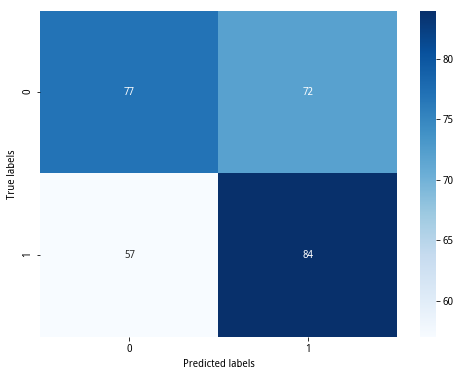

In [4]:
# sklearn接口形式
import lightgbm as lgb
import seaborn as sns
print('version', lgb.__version__)

# ## 导入LightGBM模型
from lightgbm.sklearn import LGBMClassifier
# ## 定义 LightGBM 模型，verbose为1显示训练过程 
clf = LGBMClassifier(objective='binary', num_leaves=50, learning_rate=0.05, n_estimators=100, verbose=1)
# # 在训练集上训练LightGBM模型
clf.fit(x_train, y_train, eval_set=[(x_eval, y_eval)], eval_metric='l1', early_stopping_rounds=5)
## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
eval_predict = clf.predict(x_eval)
test_predict = clf.predict(x_test)

from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The train accuracy of the LGB is:',metrics.accuracy_score(y_train,train_predict))
print('The eval accuracy of the LGB is:',metrics.accuracy_score(y_eval,eval_predict))
print('The test accuracy of the LGB is:',metrics.accuracy_score(y_test,test_predict))

## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

# 利用热力图对于结果进行可视化
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 5.3 模型参数调优

In [8]:
# sklearn接口形式
import lightgbm as lgb
import seaborn as sns
print('version', lgb.__version__)

# ## 导入LightGBM模型
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# 搜索参数
# params = {
#     'boosting_type': ['gbdt', 'dart'],  # 设置提升类型
#     'num_leaves': [31, 50, 100],  # 叶子节点数
#     'max_depth': [3, 4, 5],
#     'n_estimators': [100, 300, 500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1],  # 学习速率
#     'feature_fraction': [0.8, 0.9],  # 建树的特征选择比例
#     'bagging_fraction': [0.8, 0.9],  # 建树的样本采样比例
#     'bagging_freq': [5, 8],  # k 意味着每 k 次迭代执行bagging
# }
# 由于时间过长，减少搜索参数
params = {
    'num_leaves': [31, 50, 100],  # 叶子节点数
    'max_depth': [3, 5, 8],
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05],  # 学习速率
}

# ## 定义 LightGBM 模型，verbose <0 显示致命的, =0 显示错误 (警告), >0 显示信息 
lgb_class = LGBMClassifier(objective='binary', verbose=1)
clf = GridSearchCV(lgb_class, params, scoring='roc_auc', cv=5, n_jobs=1, verbose=1)

# # 在训练集上训练LightGBM模型
clf.fit(x_train, y_train, eval_set=[(x_eval, y_eval)], eval_metric='l1', early_stopping_rounds=5)
print('search complete!!!')

version 2.2.2
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[1]	valid_0's l1: 0.501149	valid_0's binary_logloss: 0.696022
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501007	valid_0's binary_logloss: 0.695745
[3]	valid_0's l1: 0.500871	valid_0's binary_logloss: 0.695495
[4]	valid_0's l1: 0.500774	valid_0's binary_logloss: 0.695296
[5]	valid_0's l1: 0.500636	valid_0's binary_logloss: 0.695055
[6]	valid_0's l1: 0.500541	valid_0's binary_logloss: 0.694882
[7]	valid_0's l1: 0.500405	valid_0's binary_logloss: 0.694661
[8]	valid_0's l1: 0.500311	valid_0's binary_logloss: 0.694513
[9]	valid_0's l1: 0.500212	valid_0's binary_logloss: 0.69437
[10]	valid_0's l1: 0.500079	valid_0's binary_logloss: 0.694176
[11]	valid_0's l1: 0.499982	valid_0's binary_logloss: 0.694057
[12]	valid_0's l1: 0.499884	valid_0's binary_logloss: 0.693953
[13]	valid_0's l1: 0.49977	valid_0's binary_logloss: 0.693817
[14]	valid_0's l1: 0.499681	valid_0's binary_logloss: 0

[1]	valid_0's l1: 0.501158	valid_0's binary_logloss: 0.696009
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501045	valid_0's binary_logloss: 0.695767
[3]	valid_0's l1: 0.501061	valid_0's binary_logloss: 0.695775
[4]	valid_0's l1: 0.500953	valid_0's binary_logloss: 0.695547
[5]	valid_0's l1: 0.500969	valid_0's binary_logloss: 0.695568
[6]	valid_0's l1: 0.500944	valid_0's binary_logloss: 0.695518
[7]	valid_0's l1: 0.500817	valid_0's binary_logloss: 0.695262
[8]	valid_0's l1: 0.500853	valid_0's binary_logloss: 0.695341
[9]	valid_0's l1: 0.500873	valid_0's binary_logloss: 0.695392
[10]	valid_0's l1: 0.500831	valid_0's binary_logloss: 0.695308
[11]	valid_0's l1: 0.500815	valid_0's binary_logloss: 0.695299
[12]	valid_0's l1: 0.500851	valid_0's binary_logloss: 0.695388
Early stopping, best iteration is:
[7]	valid_0's l1: 0.500817	valid_0's binary_logloss: 0.695262
[1]	valid_0's l1: 0.501155	valid_0's binary_logloss: 0.696003
Training until validation scores 

[80]	valid_0's l1: 0.493199	valid_0's binary_logloss: 0.682583
[81]	valid_0's l1: 0.493075	valid_0's binary_logloss: 0.682365
[82]	valid_0's l1: 0.493038	valid_0's binary_logloss: 0.682344
[83]	valid_0's l1: 0.492932	valid_0's binary_logloss: 0.682264
[84]	valid_0's l1: 0.492864	valid_0's binary_logloss: 0.682194
[85]	valid_0's l1: 0.492861	valid_0's binary_logloss: 0.68219
[86]	valid_0's l1: 0.492825	valid_0's binary_logloss: 0.682176
[87]	valid_0's l1: 0.492759	valid_0's binary_logloss: 0.682115
[88]	valid_0's l1: 0.492637	valid_0's binary_logloss: 0.681903
[89]	valid_0's l1: 0.492593	valid_0's binary_logloss: 0.681932
[90]	valid_0's l1: 0.492519	valid_0's binary_logloss: 0.681856
[91]	valid_0's l1: 0.492516	valid_0's binary_logloss: 0.681853
[92]	valid_0's l1: 0.492452	valid_0's binary_logloss: 0.681795
[93]	valid_0's l1: 0.492416	valid_0's binary_logloss: 0.681787
[94]	valid_0's l1: 0.492283	valid_0's binary_logloss: 0.681641
[95]	valid_0's l1: 0.49228	valid_0's binary_logloss: 0.6

[38]	valid_0's l1: 0.496934	valid_0's binary_logloss: 0.687958
[39]	valid_0's l1: 0.496844	valid_0's binary_logloss: 0.687821
[40]	valid_0's l1: 0.496736	valid_0's binary_logloss: 0.687617
[41]	valid_0's l1: 0.496612	valid_0's binary_logloss: 0.687442
[42]	valid_0's l1: 0.496549	valid_0's binary_logloss: 0.687369
[43]	valid_0's l1: 0.496393	valid_0's binary_logloss: 0.687107
[44]	valid_0's l1: 0.496304	valid_0's binary_logloss: 0.686979
[45]	valid_0's l1: 0.496275	valid_0's binary_logloss: 0.686964
[46]	valid_0's l1: 0.496154	valid_0's binary_logloss: 0.686807
[47]	valid_0's l1: 0.496091	valid_0's binary_logloss: 0.686651
[48]	valid_0's l1: 0.49603	valid_0's binary_logloss: 0.686587
[49]	valid_0's l1: 0.495877	valid_0's binary_logloss: 0.686339
[50]	valid_0's l1: 0.495815	valid_0's binary_logloss: 0.686184
[51]	valid_0's l1: 0.495728	valid_0's binary_logloss: 0.686067
[52]	valid_0's l1: 0.495576	valid_0's binary_logloss: 0.685827
[53]	valid_0's l1: 0.495562	valid_0's binary_logloss: 0.

[1]	valid_0's l1: 0.501228	valid_0's binary_logloss: 0.696199
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501127	valid_0's binary_logloss: 0.695984
[3]	valid_0's l1: 0.500967	valid_0's binary_logloss: 0.695633
[4]	valid_0's l1: 0.500868	valid_0's binary_logloss: 0.695427
[5]	valid_0's l1: 0.50071	valid_0's binary_logloss: 0.695087
[6]	valid_0's l1: 0.500613	valid_0's binary_logloss: 0.69489
[7]	valid_0's l1: 0.50038	valid_0's binary_logloss: 0.694409
[8]	valid_0's l1: 0.500284	valid_0's binary_logloss: 0.69422
[9]	valid_0's l1: 0.500054	valid_0's binary_logloss: 0.693754
[10]	valid_0's l1: 0.49996	valid_0's binary_logloss: 0.693573
[11]	valid_0's l1: 0.499807	valid_0's binary_logloss: 0.693253
[12]	valid_0's l1: 0.49958	valid_0's binary_logloss: 0.692806
[13]	valid_0's l1: 0.499488	valid_0's binary_logloss: 0.692615
[14]	valid_0's l1: 0.499337	valid_0's binary_logloss: 0.692307
[15]	valid_0's l1: 0.499246	valid_0's binary_logloss: 0.692143
[16]	vali

[1]	valid_0's l1: 0.501158	valid_0's binary_logloss: 0.696009
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501045	valid_0's binary_logloss: 0.695767
[3]	valid_0's l1: 0.501061	valid_0's binary_logloss: 0.695775
[4]	valid_0's l1: 0.500953	valid_0's binary_logloss: 0.695547
[5]	valid_0's l1: 0.500969	valid_0's binary_logloss: 0.695568
[6]	valid_0's l1: 0.500944	valid_0's binary_logloss: 0.695518
[7]	valid_0's l1: 0.500817	valid_0's binary_logloss: 0.695262
[8]	valid_0's l1: 0.500853	valid_0's binary_logloss: 0.695341
[9]	valid_0's l1: 0.500873	valid_0's binary_logloss: 0.695392
[10]	valid_0's l1: 0.500831	valid_0's binary_logloss: 0.695308
[11]	valid_0's l1: 0.500815	valid_0's binary_logloss: 0.695299
[12]	valid_0's l1: 0.500851	valid_0's binary_logloss: 0.695388
Early stopping, best iteration is:
[7]	valid_0's l1: 0.500817	valid_0's binary_logloss: 0.695262
[1]	valid_0's l1: 0.501155	valid_0's binary_logloss: 0.696003
Training until validation scores 

[80]	valid_0's l1: 0.493199	valid_0's binary_logloss: 0.682583
[81]	valid_0's l1: 0.493075	valid_0's binary_logloss: 0.682365
[82]	valid_0's l1: 0.493038	valid_0's binary_logloss: 0.682344
[83]	valid_0's l1: 0.492932	valid_0's binary_logloss: 0.682264
[84]	valid_0's l1: 0.492864	valid_0's binary_logloss: 0.682194
[85]	valid_0's l1: 0.492861	valid_0's binary_logloss: 0.68219
[86]	valid_0's l1: 0.492825	valid_0's binary_logloss: 0.682176
[87]	valid_0's l1: 0.492759	valid_0's binary_logloss: 0.682115
[88]	valid_0's l1: 0.492637	valid_0's binary_logloss: 0.681903
[89]	valid_0's l1: 0.492593	valid_0's binary_logloss: 0.681932
[90]	valid_0's l1: 0.492519	valid_0's binary_logloss: 0.681856
[91]	valid_0's l1: 0.492516	valid_0's binary_logloss: 0.681853
[92]	valid_0's l1: 0.492452	valid_0's binary_logloss: 0.681795
[93]	valid_0's l1: 0.492416	valid_0's binary_logloss: 0.681787
[94]	valid_0's l1: 0.492283	valid_0's binary_logloss: 0.681641
[95]	valid_0's l1: 0.49228	valid_0's binary_logloss: 0.6

[1]	valid_0's l1: 0.501158	valid_0's binary_logloss: 0.696009
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501045	valid_0's binary_logloss: 0.695767
[3]	valid_0's l1: 0.501061	valid_0's binary_logloss: 0.695775
[4]	valid_0's l1: 0.500953	valid_0's binary_logloss: 0.695547
[5]	valid_0's l1: 0.500969	valid_0's binary_logloss: 0.695568
[6]	valid_0's l1: 0.500944	valid_0's binary_logloss: 0.695518
[7]	valid_0's l1: 0.500817	valid_0's binary_logloss: 0.695262
[8]	valid_0's l1: 0.500853	valid_0's binary_logloss: 0.695341
[9]	valid_0's l1: 0.500873	valid_0's binary_logloss: 0.695392
[10]	valid_0's l1: 0.500831	valid_0's binary_logloss: 0.695308
[11]	valid_0's l1: 0.500815	valid_0's binary_logloss: 0.695299
[12]	valid_0's l1: 0.500851	valid_0's binary_logloss: 0.695388
Early stopping, best iteration is:
[7]	valid_0's l1: 0.500817	valid_0's binary_logloss: 0.695262
[1]	valid_0's l1: 0.501155	valid_0's binary_logloss: 0.696003
Training until validation scores 

[69]	valid_0's l1: 0.494013	valid_0's binary_logloss: 0.683536
[70]	valid_0's l1: 0.493902	valid_0's binary_logloss: 0.683431
[71]	valid_0's l1: 0.493898	valid_0's binary_logloss: 0.683426
[72]	valid_0's l1: 0.493757	valid_0's binary_logloss: 0.683237
[73]	valid_0's l1: 0.493688	valid_0's binary_logloss: 0.683157
[74]	valid_0's l1: 0.493673	valid_0's binary_logloss: 0.68317
[75]	valid_0's l1: 0.493547	valid_0's binary_logloss: 0.682944
[76]	valid_0's l1: 0.493439	valid_0's binary_logloss: 0.682851
[77]	valid_0's l1: 0.493372	valid_0's binary_logloss: 0.682783
[78]	valid_0's l1: 0.493369	valid_0's binary_logloss: 0.682779
[79]	valid_0's l1: 0.493337	valid_0's binary_logloss: 0.68276
[80]	valid_0's l1: 0.493199	valid_0's binary_logloss: 0.682583
[81]	valid_0's l1: 0.493075	valid_0's binary_logloss: 0.682365
[82]	valid_0's l1: 0.493038	valid_0's binary_logloss: 0.682344
[83]	valid_0's l1: 0.492932	valid_0's binary_logloss: 0.682264
[84]	valid_0's l1: 0.492864	valid_0's binary_logloss: 0.6

[218]	valid_0's l1: 0.483978	valid_0's binary_logloss: 0.672187
[219]	valid_0's l1: 0.483984	valid_0's binary_logloss: 0.672242
[220]	valid_0's l1: 0.483975	valid_0's binary_logloss: 0.672351
[221]	valid_0's l1: 0.483997	valid_0's binary_logloss: 0.672485
[222]	valid_0's l1: 0.483918	valid_0's binary_logloss: 0.672305
[223]	valid_0's l1: 0.483884	valid_0's binary_logloss: 0.672242
Early stopping, best iteration is:
[218]	valid_0's l1: 0.483978	valid_0's binary_logloss: 0.672187
[1]	valid_0's l1: 0.501158	valid_0's binary_logloss: 0.696009
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501045	valid_0's binary_logloss: 0.695767
[3]	valid_0's l1: 0.501061	valid_0's binary_logloss: 0.695775
[4]	valid_0's l1: 0.500953	valid_0's binary_logloss: 0.695547
[5]	valid_0's l1: 0.500969	valid_0's binary_logloss: 0.695568
[6]	valid_0's l1: 0.500944	valid_0's binary_logloss: 0.695518
[7]	valid_0's l1: 0.500817	valid_0's binary_logloss: 0.695262
[8]	valid_0's l1: 0.50

[36]	valid_0's l1: 0.497136	valid_0's binary_logloss: 0.6883
[37]	valid_0's l1: 0.49701	valid_0's binary_logloss: 0.688115
[38]	valid_0's l1: 0.496934	valid_0's binary_logloss: 0.687958
[39]	valid_0's l1: 0.496844	valid_0's binary_logloss: 0.687821
[40]	valid_0's l1: 0.496736	valid_0's binary_logloss: 0.687617
[41]	valid_0's l1: 0.496612	valid_0's binary_logloss: 0.687442
[42]	valid_0's l1: 0.496549	valid_0's binary_logloss: 0.687369
[43]	valid_0's l1: 0.496393	valid_0's binary_logloss: 0.687107
[44]	valid_0's l1: 0.496304	valid_0's binary_logloss: 0.686979
[45]	valid_0's l1: 0.496275	valid_0's binary_logloss: 0.686964
[46]	valid_0's l1: 0.496154	valid_0's binary_logloss: 0.686807
[47]	valid_0's l1: 0.496091	valid_0's binary_logloss: 0.686651
[48]	valid_0's l1: 0.49603	valid_0's binary_logloss: 0.686587
[49]	valid_0's l1: 0.495877	valid_0's binary_logloss: 0.686339
[50]	valid_0's l1: 0.495815	valid_0's binary_logloss: 0.686184
[51]	valid_0's l1: 0.495728	valid_0's binary_logloss: 0.686

[173]	valid_0's l1: 0.486505	valid_0's binary_logloss: 0.674612
[174]	valid_0's l1: 0.486474	valid_0's binary_logloss: 0.674637
[175]	valid_0's l1: 0.486422	valid_0's binary_logloss: 0.674619
[176]	valid_0's l1: 0.48642	valid_0's binary_logloss: 0.67462
[177]	valid_0's l1: 0.486309	valid_0's binary_logloss: 0.674404
[178]	valid_0's l1: 0.486225	valid_0's binary_logloss: 0.674402
[179]	valid_0's l1: 0.486202	valid_0's binary_logloss: 0.674509
[180]	valid_0's l1: 0.486031	valid_0's binary_logloss: 0.674192
[181]	valid_0's l1: 0.486036	valid_0's binary_logloss: 0.674243
[182]	valid_0's l1: 0.486036	valid_0's binary_logloss: 0.674245
[183]	valid_0's l1: 0.485866	valid_0's binary_logloss: 0.673935
[184]	valid_0's l1: 0.485834	valid_0's binary_logloss: 0.673926
[185]	valid_0's l1: 0.485799	valid_0's binary_logloss: 0.673948
[186]	valid_0's l1: 0.485757	valid_0's binary_logloss: 0.673929
[187]	valid_0's l1: 0.485724	valid_0's binary_logloss: 0.673923
[188]	valid_0's l1: 0.485645	valid_0's bin

[1]	valid_0's l1: 0.501228	valid_0's binary_logloss: 0.696199
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501127	valid_0's binary_logloss: 0.695984
[3]	valid_0's l1: 0.500967	valid_0's binary_logloss: 0.695633
[4]	valid_0's l1: 0.500868	valid_0's binary_logloss: 0.695427
[5]	valid_0's l1: 0.50071	valid_0's binary_logloss: 0.695087
[6]	valid_0's l1: 0.500613	valid_0's binary_logloss: 0.69489
[7]	valid_0's l1: 0.50038	valid_0's binary_logloss: 0.694409
[8]	valid_0's l1: 0.500284	valid_0's binary_logloss: 0.69422
[9]	valid_0's l1: 0.500054	valid_0's binary_logloss: 0.693754
[10]	valid_0's l1: 0.49996	valid_0's binary_logloss: 0.693573
[11]	valid_0's l1: 0.499807	valid_0's binary_logloss: 0.693253
[12]	valid_0's l1: 0.49958	valid_0's binary_logloss: 0.692806
[13]	valid_0's l1: 0.499488	valid_0's binary_logloss: 0.692615
[14]	valid_0's l1: 0.499337	valid_0's binary_logloss: 0.692307
[15]	valid_0's l1: 0.499246	valid_0's binary_logloss: 0.692143
[16]	vali

[140]	valid_0's l1: 0.488784	valid_0's binary_logloss: 0.677354
[141]	valid_0's l1: 0.488739	valid_0's binary_logloss: 0.677322
[142]	valid_0's l1: 0.488691	valid_0's binary_logloss: 0.677348
[143]	valid_0's l1: 0.488521	valid_0's binary_logloss: 0.677015
[144]	valid_0's l1: 0.488438	valid_0's binary_logloss: 0.676987
[145]	valid_0's l1: 0.488435	valid_0's binary_logloss: 0.676992
[146]	valid_0's l1: 0.48844	valid_0's binary_logloss: 0.677035
[147]	valid_0's l1: 0.488271	valid_0's binary_logloss: 0.676709
[148]	valid_0's l1: 0.488155	valid_0's binary_logloss: 0.67663
[149]	valid_0's l1: 0.488128	valid_0's binary_logloss: 0.676651
[150]	valid_0's l1: 0.488125	valid_0's binary_logloss: 0.676651
[151]	valid_0's l1: 0.487958	valid_0's binary_logloss: 0.676331
[152]	valid_0's l1: 0.48787	valid_0's binary_logloss: 0.676319
[153]	valid_0's l1: 0.487842	valid_0's binary_logloss: 0.676343
[154]	valid_0's l1: 0.487847	valid_0's binary_logloss: 0.676388
[155]	valid_0's l1: 0.487741	valid_0's bina

[58]	valid_0's l1: 0.494696	valid_0's binary_logloss: 0.690602
[59]	valid_0's l1: 0.494567	valid_0's binary_logloss: 0.690553
[60]	valid_0's l1: 0.494465	valid_0's binary_logloss: 0.690479
[61]	valid_0's l1: 0.494383	valid_0's binary_logloss: 0.690451
[62]	valid_0's l1: 0.494247	valid_0's binary_logloss: 0.690308
[63]	valid_0's l1: 0.494165	valid_0's binary_logloss: 0.690285
[64]	valid_0's l1: 0.494038	valid_0's binary_logloss: 0.690172
[65]	valid_0's l1: 0.493985	valid_0's binary_logloss: 0.690192
[66]	valid_0's l1: 0.493881	valid_0's binary_logloss: 0.690116
[67]	valid_0's l1: 0.493902	valid_0's binary_logloss: 0.690384
[68]	valid_0's l1: 0.493756	valid_0's binary_logloss: 0.690291
[69]	valid_0's l1: 0.493607	valid_0's binary_logloss: 0.690123
[70]	valid_0's l1: 0.493628	valid_0's binary_logloss: 0.690401
[71]	valid_0's l1: 0.493481	valid_0's binary_logloss: 0.690244
Early stopping, best iteration is:
[66]	valid_0's l1: 0.493881	valid_0's binary_logloss: 0.690116
[1]	valid_0's l1: 0.

[1]	valid_0's l1: 0.501158	valid_0's binary_logloss: 0.696009
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501045	valid_0's binary_logloss: 0.695767
[3]	valid_0's l1: 0.501061	valid_0's binary_logloss: 0.695775
[4]	valid_0's l1: 0.500953	valid_0's binary_logloss: 0.695547
[5]	valid_0's l1: 0.500969	valid_0's binary_logloss: 0.695568
[6]	valid_0's l1: 0.500944	valid_0's binary_logloss: 0.695518
[7]	valid_0's l1: 0.500817	valid_0's binary_logloss: 0.695262
[8]	valid_0's l1: 0.500853	valid_0's binary_logloss: 0.695341
[9]	valid_0's l1: 0.500873	valid_0's binary_logloss: 0.695392
[10]	valid_0's l1: 0.500831	valid_0's binary_logloss: 0.695308
[11]	valid_0's l1: 0.500815	valid_0's binary_logloss: 0.695299
[12]	valid_0's l1: 0.500851	valid_0's binary_logloss: 0.695388
Early stopping, best iteration is:
[7]	valid_0's l1: 0.500817	valid_0's binary_logloss: 0.695262
[1]	valid_0's l1: 0.501155	valid_0's binary_logloss: 0.696003
Training until validation scores 

[76]	valid_0's l1: 0.486949	valid_0's binary_logloss: 0.681641
[77]	valid_0's l1: 0.486759	valid_0's binary_logloss: 0.681563
[78]	valid_0's l1: 0.486587	valid_0's binary_logloss: 0.681461
[79]	valid_0's l1: 0.48643	valid_0's binary_logloss: 0.68142
[80]	valid_0's l1: 0.486259	valid_0's binary_logloss: 0.681207
[81]	valid_0's l1: 0.486105	valid_0's binary_logloss: 0.681183
[82]	valid_0's l1: 0.486051	valid_0's binary_logloss: 0.681228
[83]	valid_0's l1: 0.485883	valid_0's binary_logloss: 0.681022
[84]	valid_0's l1: 0.48575	valid_0's binary_logloss: 0.68106
[85]	valid_0's l1: 0.485793	valid_0's binary_logloss: 0.681347
[86]	valid_0's l1: 0.485762	valid_0's binary_logloss: 0.681429
[87]	valid_0's l1: 0.485713	valid_0's binary_logloss: 0.681602
[88]	valid_0's l1: 0.485548	valid_0's binary_logloss: 0.681403
Early stopping, best iteration is:
[83]	valid_0's l1: 0.485883	valid_0's binary_logloss: 0.681022
[1]	valid_0's l1: 0.501148	valid_0's binary_logloss: 0.696029
Training until validation

[35]	valid_0's l1: 0.496428	valid_0's binary_logloss: 0.690062
[36]	valid_0's l1: 0.496326	valid_0's binary_logloss: 0.689969
[37]	valid_0's l1: 0.496215	valid_0's binary_logloss: 0.689999
[38]	valid_0's l1: 0.496157	valid_0's binary_logloss: 0.690096
[39]	valid_0's l1: 0.496077	valid_0's binary_logloss: 0.690131
[40]	valid_0's l1: 0.495973	valid_0's binary_logloss: 0.690172
[41]	valid_0's l1: 0.495873	valid_0's binary_logloss: 0.690099
Early stopping, best iteration is:
[36]	valid_0's l1: 0.496326	valid_0's binary_logloss: 0.689969
[1]	valid_0's l1: 0.501038	valid_0's binary_logloss: 0.695867
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.500707	valid_0's binary_logloss: 0.695249
[3]	valid_0's l1: 0.50038	valid_0's binary_logloss: 0.694654
[4]	valid_0's l1: 0.500074	valid_0's binary_logloss: 0.694127
[5]	valid_0's l1: 0.499753	valid_0's binary_logloss: 0.693579
[6]	valid_0's l1: 0.49947	valid_0's binary_logloss: 0.693134
[7]	valid_0's l1: 0.499172	val

[1]	valid_0's l1: 0.501167	valid_0's binary_logloss: 0.69602
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501005	valid_0's binary_logloss: 0.695667
[3]	valid_0's l1: 0.500881	valid_0's binary_logloss: 0.6954
[4]	valid_0's l1: 0.500739	valid_0's binary_logloss: 0.695106
[5]	valid_0's l1: 0.500741	valid_0's binary_logloss: 0.695112
[6]	valid_0's l1: 0.500663	valid_0's binary_logloss: 0.694968
[7]	valid_0's l1: 0.500524	valid_0's binary_logloss: 0.694701
[8]	valid_0's l1: 0.500595	valid_0's binary_logloss: 0.694829
[9]	valid_0's l1: 0.500457	valid_0's binary_logloss: 0.694579
[10]	valid_0's l1: 0.500527	valid_0's binary_logloss: 0.694722
[11]	valid_0's l1: 0.500597	valid_0's binary_logloss: 0.69488
[12]	valid_0's l1: 0.500596	valid_0's binary_logloss: 0.69489
[13]	valid_0's l1: 0.500604	valid_0's binary_logloss: 0.694917
[14]	valid_0's l1: 0.500528	valid_0's binary_logloss: 0.694815
Early stopping, best iteration is:
[9]	valid_0's l1: 0.500457	valid_0's

[15]	valid_0's l1: 0.498431	valid_0's binary_logloss: 0.690585
[16]	valid_0's l1: 0.498356	valid_0's binary_logloss: 0.690421
[17]	valid_0's l1: 0.498097	valid_0's binary_logloss: 0.689925
[18]	valid_0's l1: 0.497834	valid_0's binary_logloss: 0.689402
[19]	valid_0's l1: 0.497761	valid_0's binary_logloss: 0.689275
[20]	valid_0's l1: 0.497534	valid_0's binary_logloss: 0.688864
[21]	valid_0's l1: 0.497462	valid_0's binary_logloss: 0.688746
[22]	valid_0's l1: 0.497391	valid_0's binary_logloss: 0.688613
[23]	valid_0's l1: 0.497175	valid_0's binary_logloss: 0.688218
[24]	valid_0's l1: 0.497106	valid_0's binary_logloss: 0.688113
[25]	valid_0's l1: 0.496911	valid_0's binary_logloss: 0.687784
[26]	valid_0's l1: 0.496695	valid_0's binary_logloss: 0.687374
[27]	valid_0's l1: 0.496503	valid_0's binary_logloss: 0.687046
[28]	valid_0's l1: 0.496301	valid_0's binary_logloss: 0.686705
[29]	valid_0's l1: 0.496086	valid_0's binary_logloss: 0.686307
[30]	valid_0's l1: 0.4959	valid_0's binary_logloss: 0.6

[13]	valid_0's l1: 0.497441	valid_0's binary_logloss: 0.690285
[14]	valid_0's l1: 0.497088	valid_0's binary_logloss: 0.6898
[15]	valid_0's l1: 0.496962	valid_0's binary_logloss: 0.689592
[16]	valid_0's l1: 0.496837	valid_0's binary_logloss: 0.689402
[17]	valid_0's l1: 0.49667	valid_0's binary_logloss: 0.689255
[18]	valid_0's l1: 0.496527	valid_0's binary_logloss: 0.689019
[19]	valid_0's l1: 0.496326	valid_0's binary_logloss: 0.68884
[20]	valid_0's l1: 0.496205	valid_0's binary_logloss: 0.688691
[21]	valid_0's l1: 0.496086	valid_0's binary_logloss: 0.688559
[22]	valid_0's l1: 0.495855	valid_0's binary_logloss: 0.688319
[23]	valid_0's l1: 0.495747	valid_0's binary_logloss: 0.688238
[24]	valid_0's l1: 0.495544	valid_0's binary_logloss: 0.688043
[25]	valid_0's l1: 0.495454	valid_0's binary_logloss: 0.687998
[26]	valid_0's l1: 0.495279	valid_0's binary_logloss: 0.687703
[27]	valid_0's l1: 0.495147	valid_0's binary_logloss: 0.687556
[28]	valid_0's l1: 0.494975	valid_0's binary_logloss: 0.687

[60]	valid_0's l1: 0.491645	valid_0's binary_logloss: 0.68005
[61]	valid_0's l1: 0.49148	valid_0's binary_logloss: 0.679952
[62]	valid_0's l1: 0.491407	valid_0's binary_logloss: 0.679855
[63]	valid_0's l1: 0.491307	valid_0's binary_logloss: 0.67969
[64]	valid_0's l1: 0.491202	valid_0's binary_logloss: 0.67968
[65]	valid_0's l1: 0.491131	valid_0's binary_logloss: 0.679589
[66]	valid_0's l1: 0.490989	valid_0's binary_logloss: 0.679557
[67]	valid_0's l1: 0.490959	valid_0's binary_logloss: 0.679544
[68]	valid_0's l1: 0.490821	valid_0's binary_logloss: 0.679316
[69]	valid_0's l1: 0.490749	valid_0's binary_logloss: 0.679203
[70]	valid_0's l1: 0.490629	valid_0's binary_logloss: 0.679181
[71]	valid_0's l1: 0.490552	valid_0's binary_logloss: 0.679083
[72]	valid_0's l1: 0.490472	valid_0's binary_logloss: 0.679104
[73]	valid_0's l1: 0.490336	valid_0's binary_logloss: 0.678884
[74]	valid_0's l1: 0.490212	valid_0's binary_logloss: 0.678899
[75]	valid_0's l1: 0.490086	valid_0's binary_logloss: 0.678

[81]	valid_0's l1: 0.486105	valid_0's binary_logloss: 0.681183
[82]	valid_0's l1: 0.486051	valid_0's binary_logloss: 0.681228
[83]	valid_0's l1: 0.485883	valid_0's binary_logloss: 0.681022
[84]	valid_0's l1: 0.48575	valid_0's binary_logloss: 0.68106
[85]	valid_0's l1: 0.485793	valid_0's binary_logloss: 0.681347
[86]	valid_0's l1: 0.485762	valid_0's binary_logloss: 0.681429
[87]	valid_0's l1: 0.485713	valid_0's binary_logloss: 0.681602
[88]	valid_0's l1: 0.485548	valid_0's binary_logloss: 0.681403
Early stopping, best iteration is:
[83]	valid_0's l1: 0.485883	valid_0's binary_logloss: 0.681022
[1]	valid_0's l1: 0.501148	valid_0's binary_logloss: 0.696029
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501018	valid_0's binary_logloss: 0.695742
[3]	valid_0's l1: 0.500759	valid_0's binary_logloss: 0.695198
[4]	valid_0's l1: 0.500583	valid_0's binary_logloss: 0.694829
[5]	valid_0's l1: 0.500328	valid_0's binary_logloss: 0.694308
[6]	valid_0's l1: 0.500154	va

[1]	valid_0's l1: 0.501038	valid_0's binary_logloss: 0.695867
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.500707	valid_0's binary_logloss: 0.695249
[3]	valid_0's l1: 0.50038	valid_0's binary_logloss: 0.694654
[4]	valid_0's l1: 0.500074	valid_0's binary_logloss: 0.694127
[5]	valid_0's l1: 0.499753	valid_0's binary_logloss: 0.693579
[6]	valid_0's l1: 0.49947	valid_0's binary_logloss: 0.693134
[7]	valid_0's l1: 0.499172	valid_0's binary_logloss: 0.692678
[8]	valid_0's l1: 0.498909	valid_0's binary_logloss: 0.692287
[9]	valid_0's l1: 0.498618	valid_0's binary_logloss: 0.691857
[10]	valid_0's l1: 0.498334	valid_0's binary_logloss: 0.69147
[11]	valid_0's l1: 0.498024	valid_0's binary_logloss: 0.691048
[12]	valid_0's l1: 0.497763	valid_0's binary_logloss: 0.690704
[13]	valid_0's l1: 0.497441	valid_0's binary_logloss: 0.690285
[14]	valid_0's l1: 0.497088	valid_0's binary_logloss: 0.6898
[15]	valid_0's l1: 0.496962	valid_0's binary_logloss: 0.689592
[16]	val

[1]	valid_0's l1: 0.501167	valid_0's binary_logloss: 0.69602
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501005	valid_0's binary_logloss: 0.695667
[3]	valid_0's l1: 0.500881	valid_0's binary_logloss: 0.6954
[4]	valid_0's l1: 0.500739	valid_0's binary_logloss: 0.695106
[5]	valid_0's l1: 0.500741	valid_0's binary_logloss: 0.695112
[6]	valid_0's l1: 0.500663	valid_0's binary_logloss: 0.694968
[7]	valid_0's l1: 0.500524	valid_0's binary_logloss: 0.694701
[8]	valid_0's l1: 0.500595	valid_0's binary_logloss: 0.694829
[9]	valid_0's l1: 0.500457	valid_0's binary_logloss: 0.694579
[10]	valid_0's l1: 0.500527	valid_0's binary_logloss: 0.694722
[11]	valid_0's l1: 0.500597	valid_0's binary_logloss: 0.69488
[12]	valid_0's l1: 0.500596	valid_0's binary_logloss: 0.69489
[13]	valid_0's l1: 0.500604	valid_0's binary_logloss: 0.694917
[14]	valid_0's l1: 0.500528	valid_0's binary_logloss: 0.694815
Early stopping, best iteration is:
[9]	valid_0's l1: 0.500457	valid_0's

[24]	valid_0's l1: 0.497106	valid_0's binary_logloss: 0.688113
[25]	valid_0's l1: 0.496911	valid_0's binary_logloss: 0.687784
[26]	valid_0's l1: 0.496695	valid_0's binary_logloss: 0.687374
[27]	valid_0's l1: 0.496503	valid_0's binary_logloss: 0.687046
[28]	valid_0's l1: 0.496301	valid_0's binary_logloss: 0.686705
[29]	valid_0's l1: 0.496086	valid_0's binary_logloss: 0.686307
[30]	valid_0's l1: 0.4959	valid_0's binary_logloss: 0.686001
[31]	valid_0's l1: 0.495839	valid_0's binary_logloss: 0.685909
[32]	valid_0's l1: 0.495622	valid_0's binary_logloss: 0.68555
[33]	valid_0's l1: 0.495447	valid_0's binary_logloss: 0.685234
[34]	valid_0's l1: 0.495214	valid_0's binary_logloss: 0.684832
[35]	valid_0's l1: 0.49505	valid_0's binary_logloss: 0.68456
[36]	valid_0's l1: 0.494872	valid_0's binary_logloss: 0.684259
[37]	valid_0's l1: 0.494796	valid_0's binary_logloss: 0.684155
[38]	valid_0's l1: 0.494627	valid_0's binary_logloss: 0.683897
[39]	valid_0's l1: 0.49448	valid_0's binary_logloss: 0.68369

[29]	valid_0's l1: 0.497386	valid_0's binary_logloss: 0.690832
[30]	valid_0's l1: 0.497191	valid_0's binary_logloss: 0.690685
[31]	valid_0's l1: 0.497005	valid_0's binary_logloss: 0.690439
[32]	valid_0's l1: 0.496917	valid_0's binary_logloss: 0.690368
[33]	valid_0's l1: 0.496802	valid_0's binary_logloss: 0.690372
[34]	valid_0's l1: 0.496623	valid_0's binary_logloss: 0.690177
[35]	valid_0's l1: 0.496428	valid_0's binary_logloss: 0.690062
[36]	valid_0's l1: 0.496326	valid_0's binary_logloss: 0.689969
[37]	valid_0's l1: 0.496215	valid_0's binary_logloss: 0.689999
[38]	valid_0's l1: 0.496157	valid_0's binary_logloss: 0.690096
[39]	valid_0's l1: 0.496077	valid_0's binary_logloss: 0.690131
[40]	valid_0's l1: 0.495973	valid_0's binary_logloss: 0.690172
[41]	valid_0's l1: 0.495873	valid_0's binary_logloss: 0.690099
Early stopping, best iteration is:
[36]	valid_0's l1: 0.496326	valid_0's binary_logloss: 0.689969
[1]	valid_0's l1: 0.501038	valid_0's binary_logloss: 0.695867
Training until valida

[91]	valid_0's l1: 0.488633	valid_0's binary_logloss: 0.678311
[92]	valid_0's l1: 0.488572	valid_0's binary_logloss: 0.678208
[93]	valid_0's l1: 0.488538	valid_0's binary_logloss: 0.678192
[94]	valid_0's l1: 0.488478	valid_0's binary_logloss: 0.678366
[95]	valid_0's l1: 0.488408	valid_0's binary_logloss: 0.678459
[96]	valid_0's l1: 0.488365	valid_0's binary_logloss: 0.678426
[97]	valid_0's l1: 0.488326	valid_0's binary_logloss: 0.678418
[98]	valid_0's l1: 0.488265	valid_0's binary_logloss: 0.678637
Early stopping, best iteration is:
[93]	valid_0's l1: 0.488538	valid_0's binary_logloss: 0.678192
[1]	valid_0's l1: 0.501167	valid_0's binary_logloss: 0.69602
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501005	valid_0's binary_logloss: 0.695667
[3]	valid_0's l1: 0.500881	valid_0's binary_logloss: 0.6954
[4]	valid_0's l1: 0.500739	valid_0's binary_logloss: 0.695106
[5]	valid_0's l1: 0.500741	valid_0's binary_logloss: 0.695112
[6]	valid_0's l1: 0.500663	val

[76]	valid_0's l1: 0.486949	valid_0's binary_logloss: 0.681641
[77]	valid_0's l1: 0.486759	valid_0's binary_logloss: 0.681563
[78]	valid_0's l1: 0.486587	valid_0's binary_logloss: 0.681461
[79]	valid_0's l1: 0.48643	valid_0's binary_logloss: 0.68142
[80]	valid_0's l1: 0.486259	valid_0's binary_logloss: 0.681207
[81]	valid_0's l1: 0.486105	valid_0's binary_logloss: 0.681183
[82]	valid_0's l1: 0.486051	valid_0's binary_logloss: 0.681228
[83]	valid_0's l1: 0.485883	valid_0's binary_logloss: 0.681022
[84]	valid_0's l1: 0.48575	valid_0's binary_logloss: 0.68106
[85]	valid_0's l1: 0.485793	valid_0's binary_logloss: 0.681347
[86]	valid_0's l1: 0.485762	valid_0's binary_logloss: 0.681429
[87]	valid_0's l1: 0.485713	valid_0's binary_logloss: 0.681602
[88]	valid_0's l1: 0.485548	valid_0's binary_logloss: 0.681403
Early stopping, best iteration is:
[83]	valid_0's l1: 0.485883	valid_0's binary_logloss: 0.681022
[1]	valid_0's l1: 0.501148	valid_0's binary_logloss: 0.696029
Training until validation

[18]	valid_0's l1: 0.498686	valid_0's binary_logloss: 0.692
[19]	valid_0's l1: 0.498562	valid_0's binary_logloss: 0.691822
[20]	valid_0's l1: 0.498373	valid_0's binary_logloss: 0.691624
[21]	valid_0's l1: 0.498329	valid_0's binary_logloss: 0.691738
[22]	valid_0's l1: 0.498207	valid_0's binary_logloss: 0.691594
[23]	valid_0's l1: 0.498012	valid_0's binary_logloss: 0.691432
[24]	valid_0's l1: 0.497893	valid_0's binary_logloss: 0.691317
[25]	valid_0's l1: 0.497706	valid_0's binary_logloss: 0.691179
[26]	valid_0's l1: 0.497515	valid_0's binary_logloss: 0.691066
[27]	valid_0's l1: 0.497388	valid_0's binary_logloss: 0.690936
[28]	valid_0's l1: 0.497212	valid_0's binary_logloss: 0.690849
[29]	valid_0's l1: 0.497094	valid_0's binary_logloss: 0.690757
[30]	valid_0's l1: 0.496965	valid_0's binary_logloss: 0.69079
[31]	valid_0's l1: 0.496881	valid_0's binary_logloss: 0.690896
[32]	valid_0's l1: 0.496776	valid_0's binary_logloss: 0.690881
[33]	valid_0's l1: 0.496677	valid_0's binary_logloss: 0.690

[9]	valid_0's l1: 0.49916	valid_0's binary_logloss: 0.692406
[10]	valid_0's l1: 0.498886	valid_0's binary_logloss: 0.691969
[11]	valid_0's l1: 0.498666	valid_0's binary_logloss: 0.691683
[12]	valid_0's l1: 0.49836	valid_0's binary_logloss: 0.691218
[13]	valid_0's l1: 0.498014	valid_0's binary_logloss: 0.690696
[14]	valid_0's l1: 0.497963	valid_0's binary_logloss: 0.690723
[15]	valid_0's l1: 0.497823	valid_0's binary_logloss: 0.690562
[16]	valid_0's l1: 0.497799	valid_0's binary_logloss: 0.690672
[17]	valid_0's l1: 0.497662	valid_0's binary_logloss: 0.690546
[18]	valid_0's l1: 0.49764	valid_0's binary_logloss: 0.690689
[19]	valid_0's l1: 0.497504	valid_0's binary_logloss: 0.690605
[20]	valid_0's l1: 0.497488	valid_0's binary_logloss: 0.690745
[21]	valid_0's l1: 0.497355	valid_0's binary_logloss: 0.690686
[22]	valid_0's l1: 0.497228	valid_0's binary_logloss: 0.690657
Early stopping, best iteration is:
[17]	valid_0's l1: 0.497662	valid_0's binary_logloss: 0.690546
[1]	valid_0's l1: 0.5011

[2]	valid_0's l1: 0.500797	valid_0's binary_logloss: 0.69527
[3]	valid_0's l1: 0.500554	valid_0's binary_logloss: 0.694783
[4]	valid_0's l1: 0.50048	valid_0's binary_logloss: 0.694633
[5]	valid_0's l1: 0.500387	valid_0's binary_logloss: 0.694468
[6]	valid_0's l1: 0.500453	valid_0's binary_logloss: 0.694621
[7]	valid_0's l1: 0.500514	valid_0's binary_logloss: 0.694782
[8]	valid_0's l1: 0.500457	valid_0's binary_logloss: 0.694724
[9]	valid_0's l1: 0.500495	valid_0's binary_logloss: 0.694795
[10]	valid_0's l1: 0.500397	valid_0's binary_logloss: 0.69462
Early stopping, best iteration is:
[5]	valid_0's l1: 0.500387	valid_0's binary_logloss: 0.694468
[1]	valid_0's l1: 0.50108	valid_0's binary_logloss: 0.695823
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.500872	valid_0's binary_logloss: 0.695376
[3]	valid_0's l1: 0.50058	valid_0's binary_logloss: 0.694758
[4]	valid_0's l1: 0.500335	valid_0's binary_logloss: 0.694294
[5]	valid_0's l1: 0.500093	valid_0's bin

[39]	valid_0's l1: 0.49164	valid_0's binary_logloss: 0.680163
[40]	valid_0's l1: 0.491473	valid_0's binary_logloss: 0.679946
[41]	valid_0's l1: 0.491229	valid_0's binary_logloss: 0.679497
[42]	valid_0's l1: 0.490988	valid_0's binary_logloss: 0.679073
[43]	valid_0's l1: 0.490776	valid_0's binary_logloss: 0.678708
[44]	valid_0's l1: 0.490418	valid_0's binary_logloss: 0.678144
[45]	valid_0's l1: 0.490264	valid_0's binary_logloss: 0.67797
[46]	valid_0's l1: 0.490051	valid_0's binary_logloss: 0.677627
[47]	valid_0's l1: 0.489816	valid_0's binary_logloss: 0.677271
[48]	valid_0's l1: 0.489601	valid_0's binary_logloss: 0.67695
[49]	valid_0's l1: 0.489454	valid_0's binary_logloss: 0.676806
[50]	valid_0's l1: 0.489185	valid_0's binary_logloss: 0.676426
[51]	valid_0's l1: 0.489023	valid_0's binary_logloss: 0.676251
[52]	valid_0's l1: 0.488809	valid_0's binary_logloss: 0.67603
[53]	valid_0's l1: 0.48854	valid_0's binary_logloss: 0.675591
[54]	valid_0's l1: 0.488333	valid_0's binary_logloss: 0.6754

[8]	valid_0's l1: 0.499002	valid_0's binary_logloss: 0.691876
[9]	valid_0's l1: 0.498683	valid_0's binary_logloss: 0.691296
[10]	valid_0's l1: 0.498595	valid_0's binary_logloss: 0.691118
[11]	valid_0's l1: 0.498273	valid_0's binary_logloss: 0.690553
[12]	valid_0's l1: 0.498075	valid_0's binary_logloss: 0.690227
[13]	valid_0's l1: 0.497777	valid_0's binary_logloss: 0.689745
[14]	valid_0's l1: 0.497693	valid_0's binary_logloss: 0.689588
[15]	valid_0's l1: 0.497422	valid_0's binary_logloss: 0.689174
[16]	valid_0's l1: 0.49723	valid_0's binary_logloss: 0.688876
[17]	valid_0's l1: 0.496957	valid_0's binary_logloss: 0.688479
[18]	valid_0's l1: 0.496877	valid_0's binary_logloss: 0.688341
[19]	valid_0's l1: 0.496592	valid_0's binary_logloss: 0.68794
[20]	valid_0's l1: 0.496407	valid_0's binary_logloss: 0.687668
[21]	valid_0's l1: 0.496136	valid_0's binary_logloss: 0.68731
[22]	valid_0's l1: 0.49606	valid_0's binary_logloss: 0.687188
[23]	valid_0's l1: 0.495752	valid_0's binary_logloss: 0.68670

[12]	valid_0's l1: 0.497905	valid_0's binary_logloss: 0.691039
[13]	valid_0's l1: 0.497565	valid_0's binary_logloss: 0.690567
[14]	valid_0's l1: 0.497219	valid_0's binary_logloss: 0.690101
[15]	valid_0's l1: 0.497032	valid_0's binary_logloss: 0.689824
[16]	valid_0's l1: 0.496848	valid_0's binary_logloss: 0.689571
[17]	valid_0's l1: 0.496676	valid_0's binary_logloss: 0.689362
[18]	valid_0's l1: 0.496531	valid_0's binary_logloss: 0.689223
[19]	valid_0's l1: 0.496394	valid_0's binary_logloss: 0.689099
[20]	valid_0's l1: 0.496265	valid_0's binary_logloss: 0.689025
[21]	valid_0's l1: 0.496078	valid_0's binary_logloss: 0.688857
[22]	valid_0's l1: 0.495983	valid_0's binary_logloss: 0.688867
[23]	valid_0's l1: 0.495806	valid_0's binary_logloss: 0.688751
[24]	valid_0's l1: 0.49568	valid_0's binary_logloss: 0.688658
[25]	valid_0's l1: 0.495549	valid_0's binary_logloss: 0.688514
[26]	valid_0's l1: 0.495437	valid_0's binary_logloss: 0.688464
[27]	valid_0's l1: 0.495361	valid_0's binary_logloss: 0.

[22]	valid_0's l1: 0.498144	valid_0's binary_logloss: 0.691464
[23]	valid_0's l1: 0.497901	valid_0's binary_logloss: 0.691201
[24]	valid_0's l1: 0.497771	valid_0's binary_logloss: 0.691046
[25]	valid_0's l1: 0.497702	valid_0's binary_logloss: 0.691148
[26]	valid_0's l1: 0.497512	valid_0's binary_logloss: 0.691032
[27]	valid_0's l1: 0.497395	valid_0's binary_logloss: 0.69095
[28]	valid_0's l1: 0.497219	valid_0's binary_logloss: 0.690863
[29]	valid_0's l1: 0.497035	valid_0's binary_logloss: 0.690812
[30]	valid_0's l1: 0.496927	valid_0's binary_logloss: 0.690773
[31]	valid_0's l1: 0.496906	valid_0's binary_logloss: 0.690997
[32]	valid_0's l1: 0.496801	valid_0's binary_logloss: 0.690981
[33]	valid_0's l1: 0.496752	valid_0's binary_logloss: 0.691188
[34]	valid_0's l1: 0.496642	valid_0's binary_logloss: 0.691183
[35]	valid_0's l1: 0.496498	valid_0's binary_logloss: 0.691208
Early stopping, best iteration is:
[30]	valid_0's l1: 0.496927	valid_0's binary_logloss: 0.690773
[1]	valid_0's l1: 0.5

[15]	valid_0's l1: 0.497772	valid_0's binary_logloss: 0.69048
[16]	valid_0's l1: 0.497748	valid_0's binary_logloss: 0.690591
[17]	valid_0's l1: 0.497611	valid_0's binary_logloss: 0.690466
[18]	valid_0's l1: 0.497475	valid_0's binary_logloss: 0.690367
[19]	valid_0's l1: 0.497453	valid_0's binary_logloss: 0.690525
[20]	valid_0's l1: 0.497402	valid_0's binary_logloss: 0.690599
[21]	valid_0's l1: 0.497268	valid_0's binary_logloss: 0.690542
[22]	valid_0's l1: 0.497142	valid_0's binary_logloss: 0.690513
[23]	valid_0's l1: 0.49716	valid_0's binary_logloss: 0.690653
Early stopping, best iteration is:
[18]	valid_0's l1: 0.497475	valid_0's binary_logloss: 0.690367
[1]	valid_0's l1: 0.501182	valid_0's binary_logloss: 0.696082
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501073	valid_0's binary_logloss: 0.695879
[3]	valid_0's l1: 0.500988	valid_0's binary_logloss: 0.695703
[4]	valid_0's l1: 0.500884	valid_0's binary_logloss: 0.695538
[5]	valid_0's l1: 0.500784	v

[78]	valid_0's l1: 0.485793	valid_0's binary_logloss: 0.675519
[79]	valid_0's l1: 0.485586	valid_0's binary_logloss: 0.675146
[80]	valid_0's l1: 0.485529	valid_0's binary_logloss: 0.675303
Early stopping, best iteration is:
[75]	valid_0's l1: 0.485844	valid_0's binary_logloss: 0.674997
[1]	valid_0's l1: 0.501037	valid_0's binary_logloss: 0.695769
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.500797	valid_0's binary_logloss: 0.69527
[3]	valid_0's l1: 0.500554	valid_0's binary_logloss: 0.694783
[4]	valid_0's l1: 0.50048	valid_0's binary_logloss: 0.694633
[5]	valid_0's l1: 0.500387	valid_0's binary_logloss: 0.694468
[6]	valid_0's l1: 0.500453	valid_0's binary_logloss: 0.694621
[7]	valid_0's l1: 0.500514	valid_0's binary_logloss: 0.694782
[8]	valid_0's l1: 0.500457	valid_0's binary_logloss: 0.694724
[9]	valid_0's l1: 0.500507	valid_0's binary_logloss: 0.694816
[10]	valid_0's l1: 0.500413	valid_0's binary_logloss: 0.694642
Early stopping, best iteration is

[43]	valid_0's l1: 0.490776	valid_0's binary_logloss: 0.678708
[44]	valid_0's l1: 0.490418	valid_0's binary_logloss: 0.678144
[45]	valid_0's l1: 0.490264	valid_0's binary_logloss: 0.67797
[46]	valid_0's l1: 0.490051	valid_0's binary_logloss: 0.677627
[47]	valid_0's l1: 0.489816	valid_0's binary_logloss: 0.677271
[48]	valid_0's l1: 0.489601	valid_0's binary_logloss: 0.67695
[49]	valid_0's l1: 0.489454	valid_0's binary_logloss: 0.676806
[50]	valid_0's l1: 0.489185	valid_0's binary_logloss: 0.676426
[51]	valid_0's l1: 0.489023	valid_0's binary_logloss: 0.676251
[52]	valid_0's l1: 0.488809	valid_0's binary_logloss: 0.67603
[53]	valid_0's l1: 0.48854	valid_0's binary_logloss: 0.675591
[54]	valid_0's l1: 0.488333	valid_0's binary_logloss: 0.675407
[55]	valid_0's l1: 0.488277	valid_0's binary_logloss: 0.675373
[56]	valid_0's l1: 0.488113	valid_0's binary_logloss: 0.675294
[57]	valid_0's l1: 0.487899	valid_0's binary_logloss: 0.67515
[58]	valid_0's l1: 0.487749	valid_0's binary_logloss: 0.6751

[17]	valid_0's l1: 0.496534	valid_0's binary_logloss: 0.68759
[18]	valid_0's l1: 0.496316	valid_0's binary_logloss: 0.687135
[19]	valid_0's l1: 0.495956	valid_0's binary_logloss: 0.686441
[20]	valid_0's l1: 0.495617	valid_0's binary_logloss: 0.685924
[21]	valid_0's l1: 0.495319	valid_0's binary_logloss: 0.6855
[22]	valid_0's l1: 0.495132	valid_0's binary_logloss: 0.685178
[23]	valid_0's l1: 0.494789	valid_0's binary_logloss: 0.684686
[24]	valid_0's l1: 0.49456	valid_0's binary_logloss: 0.684245
[25]	valid_0's l1: 0.494355	valid_0's binary_logloss: 0.683899
[26]	valid_0's l1: 0.494248	valid_0's binary_logloss: 0.683756
[27]	valid_0's l1: 0.493961	valid_0's binary_logloss: 0.683359
[28]	valid_0's l1: 0.493782	valid_0's binary_logloss: 0.683073
[29]	valid_0's l1: 0.493458	valid_0's binary_logloss: 0.682659
[30]	valid_0's l1: 0.493296	valid_0's binary_logloss: 0.682451
[31]	valid_0's l1: 0.493025	valid_0's binary_logloss: 0.6821
[32]	valid_0's l1: 0.492859	valid_0's binary_logloss: 0.68188

[1]	valid_0's l1: 0.500822	valid_0's binary_logloss: 0.695351
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.500029	valid_0's binary_logloss: 0.693687
[3]	valid_0's l1: 0.498879	valid_0's binary_logloss: 0.691416
[4]	valid_0's l1: 0.498429	valid_0's binary_logloss: 0.690626
[5]	valid_0's l1: 0.497793	valid_0's binary_logloss: 0.689541
[6]	valid_0's l1: 0.497428	valid_0's binary_logloss: 0.688836
[7]	valid_0's l1: 0.497053	valid_0's binary_logloss: 0.688041
[8]	valid_0's l1: 0.496404	valid_0's binary_logloss: 0.687094
[9]	valid_0's l1: 0.495943	valid_0's binary_logloss: 0.686418
[10]	valid_0's l1: 0.495967	valid_0's binary_logloss: 0.686723
[11]	valid_0's l1: 0.495192	valid_0's binary_logloss: 0.685508
[12]	valid_0's l1: 0.494522	valid_0's binary_logloss: 0.684252
[13]	valid_0's l1: 0.49417	valid_0's binary_logloss: 0.683861
[14]	valid_0's l1: 0.494106	valid_0's binary_logloss: 0.68389
[15]	valid_0's l1: 0.493531	valid_0's binary_logloss: 0.683348
[16]	

[1]	valid_0's l1: 0.500576	valid_0's binary_logloss: 0.694971
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.500096	valid_0's binary_logloss: 0.694222
[3]	valid_0's l1: 0.499463	valid_0's binary_logloss: 0.693457
[4]	valid_0's l1: 0.498895	valid_0's binary_logloss: 0.693017
[5]	valid_0's l1: 0.498289	valid_0's binary_logloss: 0.691866
[6]	valid_0's l1: 0.498219	valid_0's binary_logloss: 0.692466
[7]	valid_0's l1: 0.497659	valid_0's binary_logloss: 0.691796
[8]	valid_0's l1: 0.497335	valid_0's binary_logloss: 0.691477
[9]	valid_0's l1: 0.49625	valid_0's binary_logloss: 0.6894
[10]	valid_0's l1: 0.495711	valid_0's binary_logloss: 0.688965
[11]	valid_0's l1: 0.495213	valid_0's binary_logloss: 0.688901
[12]	valid_0's l1: 0.494197	valid_0's binary_logloss: 0.687147
[13]	valid_0's l1: 0.493689	valid_0's binary_logloss: 0.686774
[14]	valid_0's l1: 0.493395	valid_0's binary_logloss: 0.687032
[15]	valid_0's l1: 0.493841	valid_0's binary_logloss: 0.688205
[16]	v

[19]	valid_0's l1: 0.491816	valid_0's binary_logloss: 0.681272
[20]	valid_0's l1: 0.491805	valid_0's binary_logloss: 0.681266
[21]	valid_0's l1: 0.491494	valid_0's binary_logloss: 0.681037
[22]	valid_0's l1: 0.491499	valid_0's binary_logloss: 0.681305
[23]	valid_0's l1: 0.490849	valid_0's binary_logloss: 0.68063
[24]	valid_0's l1: 0.490614	valid_0's binary_logloss: 0.68047
[25]	valid_0's l1: 0.490417	valid_0's binary_logloss: 0.680062
[26]	valid_0's l1: 0.49019	valid_0's binary_logloss: 0.680045
[27]	valid_0's l1: 0.489578	valid_0's binary_logloss: 0.678968
[28]	valid_0's l1: 0.489047	valid_0's binary_logloss: 0.678065
[29]	valid_0's l1: 0.488772	valid_0's binary_logloss: 0.677937
[30]	valid_0's l1: 0.488467	valid_0's binary_logloss: 0.677877
[31]	valid_0's l1: 0.487583	valid_0's binary_logloss: 0.676103
[32]	valid_0's l1: 0.486885	valid_0's binary_logloss: 0.674837
[33]	valid_0's l1: 0.486682	valid_0's binary_logloss: 0.674775
[34]	valid_0's l1: 0.486224	valid_0's binary_logloss: 0.67

[3]	valid_0's l1: 0.499463	valid_0's binary_logloss: 0.693457
[4]	valid_0's l1: 0.498895	valid_0's binary_logloss: 0.693017
[5]	valid_0's l1: 0.498289	valid_0's binary_logloss: 0.691866
[6]	valid_0's l1: 0.498219	valid_0's binary_logloss: 0.692466
[7]	valid_0's l1: 0.497659	valid_0's binary_logloss: 0.691796
[8]	valid_0's l1: 0.497335	valid_0's binary_logloss: 0.691477
[9]	valid_0's l1: 0.49625	valid_0's binary_logloss: 0.6894
[10]	valid_0's l1: 0.495711	valid_0's binary_logloss: 0.688965
[11]	valid_0's l1: 0.495213	valid_0's binary_logloss: 0.688901
[12]	valid_0's l1: 0.494197	valid_0's binary_logloss: 0.687147
[13]	valid_0's l1: 0.493689	valid_0's binary_logloss: 0.686774
[14]	valid_0's l1: 0.493395	valid_0's binary_logloss: 0.687032
[15]	valid_0's l1: 0.493841	valid_0's binary_logloss: 0.688205
[16]	valid_0's l1: 0.49348	valid_0's binary_logloss: 0.688234
[17]	valid_0's l1: 0.493117	valid_0's binary_logloss: 0.688097
[18]	valid_0's l1: 0.493086	valid_0's binary_logloss: 0.689305
Ear

[8]	valid_0's l1: 0.496404	valid_0's binary_logloss: 0.687094
[9]	valid_0's l1: 0.495943	valid_0's binary_logloss: 0.686418
[10]	valid_0's l1: 0.495967	valid_0's binary_logloss: 0.686723
[11]	valid_0's l1: 0.495192	valid_0's binary_logloss: 0.685508
[12]	valid_0's l1: 0.494522	valid_0's binary_logloss: 0.684252
[13]	valid_0's l1: 0.49417	valid_0's binary_logloss: 0.683861
[14]	valid_0's l1: 0.494106	valid_0's binary_logloss: 0.68389
[15]	valid_0's l1: 0.493531	valid_0's binary_logloss: 0.683348
[16]	valid_0's l1: 0.492902	valid_0's binary_logloss: 0.682188
[17]	valid_0's l1: 0.49236	valid_0's binary_logloss: 0.681809
[18]	valid_0's l1: 0.49202	valid_0's binary_logloss: 0.681469
[19]	valid_0's l1: 0.491816	valid_0's binary_logloss: 0.681272
[20]	valid_0's l1: 0.491805	valid_0's binary_logloss: 0.681266
[21]	valid_0's l1: 0.491494	valid_0's binary_logloss: 0.681037
[22]	valid_0's l1: 0.491499	valid_0's binary_logloss: 0.681305
[23]	valid_0's l1: 0.490849	valid_0's binary_logloss: 0.68063

[1]	valid_0's l1: 0.500576	valid_0's binary_logloss: 0.694971
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.500096	valid_0's binary_logloss: 0.694222
[3]	valid_0's l1: 0.499463	valid_0's binary_logloss: 0.693457
[4]	valid_0's l1: 0.498895	valid_0's binary_logloss: 0.693017
[5]	valid_0's l1: 0.498289	valid_0's binary_logloss: 0.691866
[6]	valid_0's l1: 0.498219	valid_0's binary_logloss: 0.692466
[7]	valid_0's l1: 0.497659	valid_0's binary_logloss: 0.691796
[8]	valid_0's l1: 0.497335	valid_0's binary_logloss: 0.691477
[9]	valid_0's l1: 0.49625	valid_0's binary_logloss: 0.6894
[10]	valid_0's l1: 0.495711	valid_0's binary_logloss: 0.688965
[11]	valid_0's l1: 0.495213	valid_0's binary_logloss: 0.688901
[12]	valid_0's l1: 0.494197	valid_0's binary_logloss: 0.687147
[13]	valid_0's l1: 0.493689	valid_0's binary_logloss: 0.686774
[14]	valid_0's l1: 0.493395	valid_0's binary_logloss: 0.687032
[15]	valid_0's l1: 0.493841	valid_0's binary_logloss: 0.688205
[16]	v

[1]	valid_0's l1: 0.500425	valid_0's binary_logloss: 0.694526
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.499146	valid_0's binary_logloss: 0.692013
[3]	valid_0's l1: 0.497938	valid_0's binary_logloss: 0.68962
[4]	valid_0's l1: 0.497596	valid_0's binary_logloss: 0.689048
[5]	valid_0's l1: 0.496723	valid_0's binary_logloss: 0.687576
[6]	valid_0's l1: 0.496399	valid_0's binary_logloss: 0.687076
[7]	valid_0's l1: 0.495396	valid_0's binary_logloss: 0.68544
[8]	valid_0's l1: 0.494297	valid_0's binary_logloss: 0.683625
[9]	valid_0's l1: 0.492936	valid_0's binary_logloss: 0.681283
[10]	valid_0's l1: 0.492053	valid_0's binary_logloss: 0.680088
[11]	valid_0's l1: 0.491426	valid_0's binary_logloss: 0.678964
[12]	valid_0's l1: 0.491487	valid_0's binary_logloss: 0.67921
[13]	valid_0's l1: 0.491273	valid_0's binary_logloss: 0.679008
[14]	valid_0's l1: 0.490748	valid_0's binary_logloss: 0.678504
[15]	valid_0's l1: 0.489916	valid_0's binary_logloss: 0.677785
[16]	v

[15]	valid_0's l1: 0.491614	valid_0's binary_logloss: 0.693189
Early stopping, best iteration is:
[10]	valid_0's l1: 0.493292	valid_0's binary_logloss: 0.68791
[1]	valid_0's l1: 0.499873	valid_0's binary_logloss: 0.693842
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498368	valid_0's binary_logloss: 0.691546
[3]	valid_0's l1: 0.496842	valid_0's binary_logloss: 0.68947
[4]	valid_0's l1: 0.496215	valid_0's binary_logloss: 0.688619
[5]	valid_0's l1: 0.495438	valid_0's binary_logloss: 0.688266
[6]	valid_0's l1: 0.494569	valid_0's binary_logloss: 0.686886
[7]	valid_0's l1: 0.494049	valid_0's binary_logloss: 0.686528
[8]	valid_0's l1: 0.4935	valid_0's binary_logloss: 0.686414
[9]	valid_0's l1: 0.4923	valid_0's binary_logloss: 0.684783
[10]	valid_0's l1: 0.491505	valid_0's binary_logloss: 0.683958
[11]	valid_0's l1: 0.490807	valid_0's binary_logloss: 0.683884
[12]	valid_0's l1: 0.488958	valid_0's binary_logloss: 0.681472
[13]	valid_0's l1: 0.488366	valid_0's

[1]	valid_0's l1: 0.499841	valid_0's binary_logloss: 0.69327
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498341	valid_0's binary_logloss: 0.690479
[3]	valid_0's l1: 0.498144	valid_0's binary_logloss: 0.690543
[4]	valid_0's l1: 0.498074	valid_0's binary_logloss: 0.690916
[5]	valid_0's l1: 0.496927	valid_0's binary_logloss: 0.689454
[6]	valid_0's l1: 0.497087	valid_0's binary_logloss: 0.690131
[7]	valid_0's l1: 0.497153	valid_0's binary_logloss: 0.691103
[8]	valid_0's l1: 0.496512	valid_0's binary_logloss: 0.690333
[9]	valid_0's l1: 0.495506	valid_0's binary_logloss: 0.689246
[10]	valid_0's l1: 0.49431	valid_0's binary_logloss: 0.687873
[11]	valid_0's l1: 0.494024	valid_0's binary_logloss: 0.687935
[12]	valid_0's l1: 0.492861	valid_0's binary_logloss: 0.686658
[13]	valid_0's l1: 0.493037	valid_0's binary_logloss: 0.687808
[14]	valid_0's l1: 0.493684	valid_0's binary_logloss: 0.690564
[15]	valid_0's l1: 0.494209	valid_0's binary_logloss: 0.69307
[16]	v

[1]	valid_0's l1: 0.500425	valid_0's binary_logloss: 0.694526
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.499146	valid_0's binary_logloss: 0.692013
[3]	valid_0's l1: 0.497938	valid_0's binary_logloss: 0.68962
[4]	valid_0's l1: 0.497596	valid_0's binary_logloss: 0.689048
[5]	valid_0's l1: 0.496723	valid_0's binary_logloss: 0.687576
[6]	valid_0's l1: 0.496399	valid_0's binary_logloss: 0.687076
[7]	valid_0's l1: 0.495396	valid_0's binary_logloss: 0.68544
[8]	valid_0's l1: 0.494297	valid_0's binary_logloss: 0.683625
[9]	valid_0's l1: 0.492936	valid_0's binary_logloss: 0.681283
[10]	valid_0's l1: 0.492053	valid_0's binary_logloss: 0.680088
[11]	valid_0's l1: 0.491426	valid_0's binary_logloss: 0.678964
[12]	valid_0's l1: 0.491487	valid_0's binary_logloss: 0.67921
[13]	valid_0's l1: 0.491273	valid_0's binary_logloss: 0.679008
[14]	valid_0's l1: 0.490748	valid_0's binary_logloss: 0.678504
[15]	valid_0's l1: 0.489916	valid_0's binary_logloss: 0.677785
[16]	v

[13]	valid_0's l1: 0.492135	valid_0's binary_logloss: 0.69076
[14]	valid_0's l1: 0.491999	valid_0's binary_logloss: 0.691995
[15]	valid_0's l1: 0.491614	valid_0's binary_logloss: 0.693189
Early stopping, best iteration is:
[10]	valid_0's l1: 0.493292	valid_0's binary_logloss: 0.68791
[1]	valid_0's l1: 0.499873	valid_0's binary_logloss: 0.693842
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498368	valid_0's binary_logloss: 0.691546
[3]	valid_0's l1: 0.496842	valid_0's binary_logloss: 0.68947
[4]	valid_0's l1: 0.496215	valid_0's binary_logloss: 0.688619
[5]	valid_0's l1: 0.495438	valid_0's binary_logloss: 0.688266
[6]	valid_0's l1: 0.494569	valid_0's binary_logloss: 0.686886
[7]	valid_0's l1: 0.494049	valid_0's binary_logloss: 0.686528
[8]	valid_0's l1: 0.4935	valid_0's binary_logloss: 0.686414
[9]	valid_0's l1: 0.4923	valid_0's binary_logloss: 0.684783
[10]	valid_0's l1: 0.491505	valid_0's binary_logloss: 0.683958
[11]	valid_0's l1: 0.490807	valid_0's 

[1]	valid_0's l1: 0.500676	valid_0's binary_logloss: 0.69501
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.499976	valid_0's binary_logloss: 0.693718
[3]	valid_0's l1: 0.500038	valid_0's binary_logloss: 0.69391
[4]	valid_0's l1: 0.500051	valid_0's binary_logloss: 0.694254
[5]	valid_0's l1: 0.499975	valid_0's binary_logloss: 0.694351
[6]	valid_0's l1: 0.499803	valid_0's binary_logloss: 0.694391
[7]	valid_0's l1: 0.499577	valid_0's binary_logloss: 0.694341
Early stopping, best iteration is:
[2]	valid_0's l1: 0.499976	valid_0's binary_logloss: 0.693718
[1]	valid_0's l1: 0.499841	valid_0's binary_logloss: 0.69327
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498341	valid_0's binary_logloss: 0.690479
[3]	valid_0's l1: 0.498144	valid_0's binary_logloss: 0.690543
[4]	valid_0's l1: 0.498074	valid_0's binary_logloss: 0.690916
[5]	valid_0's l1: 0.496927	valid_0's binary_logloss: 0.689454
[6]	valid_0's l1: 0.497087	valid_0's bin

[1]	valid_0's l1: 0.49998	valid_0's binary_logloss: 0.693805
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497834	valid_0's binary_logloss: 0.689777
[3]	valid_0's l1: 0.496964	valid_0's binary_logloss: 0.68825
[4]	valid_0's l1: 0.495562	valid_0's binary_logloss: 0.686079
[5]	valid_0's l1: 0.493892	valid_0's binary_logloss: 0.683593
[6]	valid_0's l1: 0.493337	valid_0's binary_logloss: 0.683126
[7]	valid_0's l1: 0.491981	valid_0's binary_logloss: 0.681505
[8]	valid_0's l1: 0.49051	valid_0's binary_logloss: 0.678823
[9]	valid_0's l1: 0.488975	valid_0's binary_logloss: 0.676579
[10]	valid_0's l1: 0.489269	valid_0's binary_logloss: 0.677711
[11]	valid_0's l1: 0.488243	valid_0's binary_logloss: 0.676685
[12]	valid_0's l1: 0.488331	valid_0's binary_logloss: 0.677508
[13]	valid_0's l1: 0.487504	valid_0's binary_logloss: 0.677646
[14]	valid_0's l1: 0.487319	valid_0's binary_logloss: 0.67724
Early stopping, best iteration is:
[9]	valid_0's l1: 0.488975	valid_0'

[8]	valid_0's l1: 0.493028	valid_0's binary_logloss: 0.68427
[9]	valid_0's l1: 0.492093	valid_0's binary_logloss: 0.68256
[10]	valid_0's l1: 0.490633	valid_0's binary_logloss: 0.68097
[11]	valid_0's l1: 0.48917	valid_0's binary_logloss: 0.678713
[12]	valid_0's l1: 0.488272	valid_0's binary_logloss: 0.677289
[13]	valid_0's l1: 0.487393	valid_0's binary_logloss: 0.675807
[14]	valid_0's l1: 0.486343	valid_0's binary_logloss: 0.674324
[15]	valid_0's l1: 0.485867	valid_0's binary_logloss: 0.673972
[16]	valid_0's l1: 0.485703	valid_0's binary_logloss: 0.67394
[17]	valid_0's l1: 0.484869	valid_0's binary_logloss: 0.673044
[18]	valid_0's l1: 0.483842	valid_0's binary_logloss: 0.672492
[19]	valid_0's l1: 0.48355	valid_0's binary_logloss: 0.672442
[20]	valid_0's l1: 0.482171	valid_0's binary_logloss: 0.67043
[21]	valid_0's l1: 0.48214	valid_0's binary_logloss: 0.671283
[22]	valid_0's l1: 0.481526	valid_0's binary_logloss: 0.670743
[23]	valid_0's l1: 0.480885	valid_0's binary_logloss: 0.670321
[2

[1]	valid_0's l1: 0.499683	valid_0's binary_logloss: 0.693595
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498137	valid_0's binary_logloss: 0.691269
[3]	valid_0's l1: 0.496383	valid_0's binary_logloss: 0.688867
[4]	valid_0's l1: 0.495584	valid_0's binary_logloss: 0.688003
[5]	valid_0's l1: 0.494702	valid_0's binary_logloss: 0.687454
[6]	valid_0's l1: 0.49428	valid_0's binary_logloss: 0.687657
[7]	valid_0's l1: 0.493633	valid_0's binary_logloss: 0.687194
[8]	valid_0's l1: 0.492774	valid_0's binary_logloss: 0.687367
[9]	valid_0's l1: 0.492631	valid_0's binary_logloss: 0.688723
[10]	valid_0's l1: 0.492344	valid_0's binary_logloss: 0.689085
[11]	valid_0's l1: 0.491101	valid_0's binary_logloss: 0.688175
[12]	valid_0's l1: 0.490473	valid_0's binary_logloss: 0.689075
Early stopping, best iteration is:
[7]	valid_0's l1: 0.493633	valid_0's binary_logloss: 0.687194
[1]	valid_0's l1: 0.49998	valid_0's binary_logloss: 0.693805
Training until validation scores do

[1]	valid_0's l1: 0.500739	valid_0's binary_logloss: 0.695375
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.500217	valid_0's binary_logloss: 0.694566
[3]	valid_0's l1: 0.499029	valid_0's binary_logloss: 0.692881
[4]	valid_0's l1: 0.498693	valid_0's binary_logloss: 0.692418
[5]	valid_0's l1: 0.498086	valid_0's binary_logloss: 0.692412
[6]	valid_0's l1: 0.497232	valid_0's binary_logloss: 0.691046
[7]	valid_0's l1: 0.497169	valid_0's binary_logloss: 0.69228
[8]	valid_0's l1: 0.495819	valid_0's binary_logloss: 0.690597
[9]	valid_0's l1: 0.494719	valid_0's binary_logloss: 0.690008
[10]	valid_0's l1: 0.494339	valid_0's binary_logloss: 0.690112
[11]	valid_0's l1: 0.49345	valid_0's binary_logloss: 0.690136
[12]	valid_0's l1: 0.493034	valid_0's binary_logloss: 0.690399
[13]	valid_0's l1: 0.492896	valid_0's binary_logloss: 0.69148
[14]	valid_0's l1: 0.492481	valid_0's binary_logloss: 0.691332
Early stopping, best iteration is:
[9]	valid_0's l1: 0.494719	valid_0

[9]	valid_0's l1: 0.49358	valid_0's binary_logloss: 0.690439
Early stopping, best iteration is:
[4]	valid_0's l1: 0.496775	valid_0's binary_logloss: 0.689527
[1]	valid_0's l1: 0.501222	valid_0's binary_logloss: 0.696246
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.501065	valid_0's binary_logloss: 0.696001
[3]	valid_0's l1: 0.500901	valid_0's binary_logloss: 0.695832
[4]	valid_0's l1: 0.500713	valid_0's binary_logloss: 0.695632
[5]	valid_0's l1: 0.500073	valid_0's binary_logloss: 0.694254
[6]	valid_0's l1: 0.500044	valid_0's binary_logloss: 0.694378
[7]	valid_0's l1: 0.49945	valid_0's binary_logloss: 0.693408
[8]	valid_0's l1: 0.49884	valid_0's binary_logloss: 0.692289
[9]	valid_0's l1: 0.498806	valid_0's binary_logloss: 0.6924
[10]	valid_0's l1: 0.498585	valid_0's binary_logloss: 0.692036
[11]	valid_0's l1: 0.497875	valid_0's binary_logloss: 0.690902
[12]	valid_0's l1: 0.497871	valid_0's binary_logloss: 0.691108
[13]	valid_0's l1: 0.496938	valid_0's 

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   32.0s finished


0.4615526454290277
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
The train accuracy of the LGB is: 0.66693354683747
The eval accuracy of the LGB is: 0.5655172413793104
The test accuracy of the LGB is: 0.5655172413793104
The confusion matrix result:
 [[68 60]
 [66 96]]


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


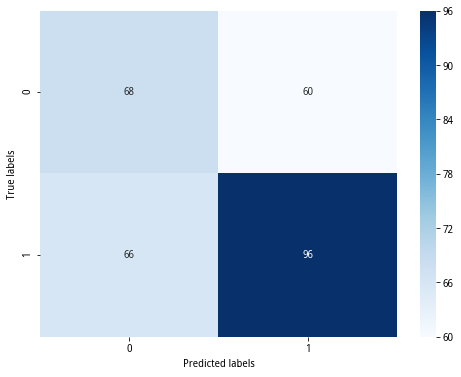

In [9]:
print(clf.best_score_)    #查看最佳分数(此处为f1_score)
print(clf.best_params_)   #查看最佳参数
clf = clf.best_estimator_  # 获取最佳模型

## 在训练集和测试集上分布利用训练好的模型进行预测
train_predict = clf.predict(x_train)
eval_predict = clf.predict(x_eval)
test_predict = clf.predict(x_test)

from sklearn import metrics

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The train accuracy of the LGB is:',metrics.accuracy_score(y_train,train_predict))
print('The eval accuracy of the LGB is:',metrics.accuracy_score(y_eval,eval_predict))
print('The test accuracy of the LGB is:',metrics.accuracy_score(y_test,test_predict))

## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

# 利用热力图对于结果进行可视化
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 5.4 模型保存和调用

In [5]:
from sklearn.externals import joblib
# 模型存储
joblib.dump(clf, 'lgb_clf_stock.pkl')

['lgb_clf_stock.pkl']

In [24]:
from sklearn.externals import joblib

# 模型加载 (todo：如果不运行之前的训练流程，直接加载模型无法使用，暂不确定原因)
clf = joblib.load('lgb_clf_stock.pkl')

# 模型预测
y_pred = clf.predict(x_test, num_iteration=clf.best_iteration_)

# 模型评估
print('The accuracy_score of prediction is:', metrics.accuracy_score(y_test, y_pred))

The accuracy_score of prediction is: 0.5551724137931034


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 5.5 特征重要性评估

In [19]:
# 特征重要度
#print('Feature importances:', list(clf.feature_importances_))

# 根据重要性，进行特征筛选。输出2列，因子名和重要性
factor_weight = pd.DataFrame({'features':list(ft_names),
                             'importance':clf.feature_importances_}).sort_values(
    #这里根据重要程度降序排列，一遍遍找到重要性最高的特征
    by='importance', ascending = False)
#检查结果，可以看到重要性和决策树略有差异
factor_weight

,features,importance
42,MAWVAD,24
38,BR,24
59,sales_to_price_ratio,20
26,ATR14,18
55,TVSTD6,17
13,turnover_volatility,15
63,VMACD,15
7,circulating_market_cap,13
58,TVSTD20,12
14,cash_flow_to_price_ratio,12


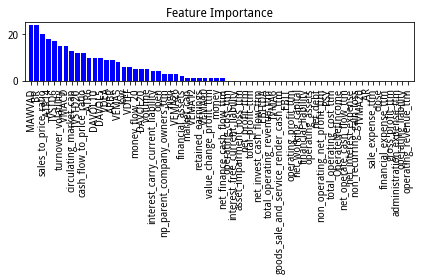

In [21]:
# 绘制特征重要性图像
plt.title('Feature Importance')
# 特征数量 和 特征重要性
plt.bar(range(factor_weight.shape[0]), factor_weight['importance'], color='blue', align='center')
# 横轴特征名
plt.xticks(range(factor_weight.shape[0]), factor_weight['features'], rotation=90)
           # fontdict={'color':'red', 'size':16})
plt.xlim([-1, factor_weight.shape[0]])
plt.tight_layout()

# 6. TopKDropN选股择时策略
原理：   
1. 基于模型对股票池股票预测“涨”的概率值进行排序，选择topK个股票进行买入
2. 基于模型对持仓股票预测“跌”的概率值进行排序，清仓N支股票

In [21]:
# 从之前测试数据注，每个股票抽取第一天的数据，模拟每天交易过程的选股
import numpy as np
stk_lst, val_lst = [], []
ft_len = len(ft_names)
print('ft_len', ft_len)

for key, val in df_test_dict.items():
    # 一维转二维
    # del df_all['lab']，这种方法会影响df_dict里的数据，后续df_dict里的lab列无法获取
    x = val.loc[:, val.columns != 'lab']
    val_array = x.iloc[0, :].values.reshape(1, -1)
    if val_array.shape[1] != ft_len:
       continue
    stk_lst.append(key)
    val_lst.append(val_array)
    
val_all = np.concatenate(val_lst, axis=0)
print('val_all shape:', val_all.shape)

# 如下预测忘加标准化处理，请自行加入
#from sklearn import preprocessing
#val_all=preprocessing.StandardScaler()
#val_all=scaler.fit_transform(val_all)

ft_len 66
val_all shape: (8, 66)


In [40]:
import pandas as pd
# 获取
test_probs = clf.predict_proba(val_all)
print('test_probs', test_probs)

# 第一列是标签0的概率，第二列是标签1的概率
data_dict = {'stk': stk_lst, 'prob': test_probs[:, 1]}
df_pred = pd.DataFrame(data_dict, columns=data_dict.keys())
df_pred.sort_values(by="prob", inplace=True, ascending=False)  # inplace: 原地修改
df_pred

test_probs [[0.6071636758820642 0.39283632411793573]
 [0.662436919053922 0.337563080946078]
 [0.5698603754419066 0.4301396245580934]
 [0.5661390845594774 0.4338609154405227]
 [0.6975304160401822 0.3024695839598178]
 [0.6817010047942658 0.3182989952057343]
 [0.5031193464425533 0.4968806535574467]
 [0.7207876371284441 0.27921236287155593]]


,stk,prob
6,000166.XSHE,0.496881
3,000069.XSHE,0.433861
2,000066.XSHE,0.430140
0,000001.XSHE,0.392836
1,000002.XSHE,0.337563
5,000157.XSHE,0.318299
4,000100.XSHE,0.302470
7,000333.XSHE,0.279212


In [42]:
# 选择TOP3的股票
df_pred['stk'][:3]

6    000166.XSHE
3    000069.XSHE
2    000066.XSHE
Name: stk, dtype: object

In [43]:
# 第一列是标签0的概率，第二列是标签1的概率
data_dict = {'stk': stk_lst, 'prob': test_probs[:, 0]}
df_pred = pd.DataFrame(data_dict, columns=data_dict.keys())
df_pred.sort_values(by="prob", inplace=True, ascending=False)  # inplace: 原地修改
print('ori:\n', df_pred)

# 将持仓的top3做空
print('dropN\n', df_pred['stk'][:3])

ori:
            stk      prob
7  000333.XSHE  0.720788
4  000100.XSHE  0.697530
5  000157.XSHE  0.681701
1  000002.XSHE  0.662437
0  000001.XSHE  0.607164
2  000066.XSHE  0.569860
3  000069.XSHE  0.566139
6  000166.XSHE  0.503119
dropN
 7    000333.XSHE
4    000100.XSHE
5    000157.XSHE
Name: stk, dtype: object
